In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)
import lightgbm as lgb
pd.set_option('precision', 2)
from sklearn.model_selection import cross_val_predict, KFold, LeaveOneOut
pd.options.display.float_format = '{:20,.6f}'.format
np.set_printoptions(suppress=False)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
# %config InlineBackend.figure_format = 'svg'
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (6, 4)
matplotlib.rcParams.update({'font.size': 14})
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def calc_(v1,v2,v3,v4,v5):
        return v1*v2* (8.947119691 if v3 > 2.54 else 3.657095255)* (8.451397398 if v4 > 3.624067868 else 6.641123451)* (5 if v5 > 1979 else 4.28)

In [32]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

In [33]:
raw_train.describe().T # Данные по обучающей выборке

count                 mean                  std                  min                  25%                  50%                  75%                  max
Id                   10,000.000000         8,383.407700         4,859.019020             0.000000         4,169.500000         8,394.500000        12,592.500000        16,798.000000
DistrictId           10,000.000000            50.400800            43.587592             0.000000            20.000000            36.000000            75.000000           209.000000
Rooms                10,000.000000             1.890500             0.839512             0.000000             1.000000             2.000000             2.000000            19.000000
Square               10,000.000000            56.315775            21.058732             1.136859            41.774881            52.513310            65.900625           641.065193
LifeSquare            7,887.000000            37.199645            86.241209             0.370619            22.769832            32.781260            45.128803         7,480.592129
KitchenSquare        10,000.000000             6.273300            28.560917             0.000000             1.000000             6.000000             9.000000         2,014.000000
Floor                10,000.000000             8.526700             5.241148             1.000000             4.000000             7.000000            12.000000            42.000000
HouseFloor           10,000.000000            12.609400             6.775974             0.000000             9.000000            13.000000            17.000000           117.000000
HouseYear            10,000.000000         3,990.166300       200,500.261427         1,910.000000         1,974.000000         1,977.000000         2,001.000000    20,052,011.000000
Ecology_1            10,000.000000             0.118858             0.119025             0.000000             0.017647             0.075424             0.195781             0.521867
Social_1             10,000.000000            24.687000            17.532614             0.000000             6.000000            25.000000            36.000000            74.000000
Social_2             10,000.000000         5,352.157400         4,006.799803           168.000000         1,564.000000         5,285.000000         7,227.000000        19,083.000000
Social_3             10,000.000000             8.039200            23.831875             0.000000             0.000000             2.000000             5.000000           141.000000
Healthcare_1          5,202.000000         1,142.904460         1,021.517264             0.000000           350.000000           900.000000         1,548.000000         4,849.000000
Helthcare_2          10,000.000000             1.319500             1.493601             0.000000             0.000000             1.000000             2.000000             6.000000
Shops_1              10,000.000000             4.231300             4.806341             0.000000             1.000000             3.000000             6.000000            23.000000
Price                10,000.000000       214,138.857399        92,872.293865        59,174.778028       153,872.633942       192,269.644879       249,135.462171       633,233.466570

In [34]:
raw_test.describe().T # Данные по тестовой выборке. Бывает можно в лерне исключить те записи, которые не нужны для обучения, потому что они вне диапазона фичей теста, в который нам нужно попасть.
# Но тут нет случая когда по всем фичам лерн больше или меньше, чем тестовые точки и что-то можно убрать. Поэтому будем дальше разбирать каждую фичу отдельно.

count                 mean                  std                  min                  25%                  50%                  75%                  max
Id                    5,000.000000         8,412.595400         4,832.674037             1.000000         4,221.750000         8,320.500000        12,598.250000        16,795.000000
DistrictId            5,000.000000            51.279200            44.179466             0.000000            21.000000            37.000000            77.000000           212.000000
Rooms                 5,000.000000             1.910000             0.838594             0.000000             1.000000             2.000000             2.000000            17.000000
Square                5,000.000000            56.449500            19.092787             1.378543            41.906231            52.921340            66.285129           223.453689
LifeSquare            3,959.000000            36.158810            17.825287             0.333490            23.092026            32.925087            45.174091           303.071094
KitchenSquare         5,000.000000             5.976800             9.950018             0.000000             1.000000             6.000000             9.000000           620.000000
Floor                 5,000.000000             8.632000             5.483228             1.000000             4.000000             7.000000            12.000000            78.000000
HouseFloor            5,000.000000            12.601000             6.789213             0.000000             9.000000            12.000000            17.000000            99.000000
HouseYear             5,000.000000         1,984.392600            18.573149         1,908.000000         1,973.000000         1,977.000000         2,000.000000         2,020.000000
Ecology_1             5,000.000000             0.119874             0.120070             0.000000             0.019509             0.072158             0.195781             0.521867
Social_1              5,000.000000            24.933800            17.532202             0.000000             6.000000            25.000000            36.000000            74.000000
Social_2              5,000.000000         5,406.900000         4,026.614773           168.000000         1,564.000000         5,285.000000         7,287.000000        19,083.000000
Social_3              5,000.000000             8.262600            23.863762             0.000000             0.000000             2.000000             5.000000           141.000000
Healthcare_1          2,623.000000         1,146.657263         1,044.744231             0.000000           325.000000           900.000000         1,548.000000         4,849.000000
Helthcare_2           5,000.000000             1.319400             1.479940             0.000000             0.000000             1.000000             2.000000             6.000000
Shops_1               5,000.000000             4.242800             4.777365             0.000000             1.000000             3.000000             6.000000            23.000000

In [35]:
print(len(raw_train.Id.unique()), len(raw_train)) # все id квартир уникальны, дубликатов по id в лерне нет
print(len(raw_test.Id.unique()), len(raw_test)) # все id квартир уникальны, дубликатов по id в тест нет

10000 10000
5000 5000


In [36]:
# введем типы для точек из теста и лерна, чтобы не путать данные дальше при работе с данными
raw_train['type']='learn'
raw_test['type']='test'

In [37]:
# Здесь мы объеденим датасеты в один, чтобы работать с тестовыми данными и данными обучения одновременно.
raw_data = pd.concat([raw_train,raw_test],sort=False).reset_index(drop=True)
raw_data

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  Social_3         Healthcare_1  Helthcare_2  Shops_1 Shops_2                Price   type
0      14038          35             2.000000            47.981561            29.442751             6.000000      7             9.000000       1969             0.089040         B         B        33      7976         5                  nan            0       11       B       184,966.930730  learn
1      15053          41             3.000000            65.683640            40.049543             8.000000      7             9.000000       1978             0.000070         B         B        46     10309         1           240.000000            1       16       B       300,009.450063  learn
2       4765          53             2.000000            44.947953            29.197612             0.000000      8            12.000000       1968             0.049637         B         B        34      7759         0           229.000000            1        3       B       220,925.908524  learn
3       5809          58             2.000000            53.352981            52.731512             9.000000      8            17.000000       1977             0.437885         B         B        23      5735         3         1,084.000000            0        5       B       175,616.227217  learn
4      10783          99             1.000000            39.649192            23.776169             7.000000     11            12.000000       1976             0.012339         B         B        35      5776         1         2,078.000000            2        4       B       150,226.531644  learn
...      ...         ...                  ...                  ...                  ...                  ...    ...                  ...        ...                  ...       ...       ...       ...       ...       ...                  ...          ...      ...     ...                  ...    ...
14995   8180          11             3.000000            67.133911            50.809797             6.000000      5             9.000000       1973             0.000170         B         B        36      5992         0                  nan            1        1       B                  nan   test
14996   4695           1             1.000000            40.198472            21.807061            10.000000     12            17.000000       2017             0.007122         B         B         1       264         0                  nan            0        1       B                  nan   test
14997   5783          12             3.000000            77.842178            48.282625             9.000000     23            22.000000       1989             0.090799         B         B        74     19083         2                  nan            5       15       B                  nan   test
14998   4780          62             2.000000            81.305222                  nan             0.000000      4             0.000000       1977             0.072158         B         B         2       629         1                  nan            0        0       A                  nan   test
14999  12504          30             2.000000            60.555693                  nan             1.000000     10            17.000000       1977             0.000078         B         B        22      6398       141         1,046.000000            3       23       B                  nan   test

[15000 rows x 21 columns]

In [38]:
raw_data.to_pickle('raw_data.pkl')

In [39]:
raw_data.corr(method='spearman').reset_index()[['index','Price']].sort_values('Price', ascending=False)

index                Price
16          Price             1.000000
2           Rooms             0.595328
3          Square             0.568596
4      LifeSquare             0.441275
12       Social_3             0.319785
10       Social_1             0.318099
15        Shops_1             0.311880
5   KitchenSquare             0.311176
11       Social_2             0.302016
14    Helthcare_2             0.295490
1      DistrictId             0.249454
6           Floor             0.110444
13   Healthcare_1             0.076854
7      HouseFloor             0.049340
8       HouseYear             0.022788
0              Id             0.003209
9       Ecology_1            -0.041472

In [40]:
corr = raw_data.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# Посмотрим общую кореляцию и мультиколлениарность

In [41]:
# Сразу проверим какой R2 будет на текущих необработанных данных, чтобы понять потом какую работу мы сделали (Познание в сравнении)
remain_features = ['DistrictId','Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','Healthcare_1','Helthcare_2','Shops_1']
X = raw_data[raw_data['type']=='learn'][remain_features]
y = raw_data[raw_data['type']=='learn']['Price']

In [42]:
print(X.shape)
print(y.shape)

(10000, 15)
(10000,)


In [16]:
# введем еще один особенный тип (holdout) для самопроверки результатов прогнозирования на лерне.
# Т.е. мы будем учиться не на всех 10К элементах, а на 8К, и потом проверим обобщающую способность модели на холдауте (случайно выберем 2000 квартир (80/20)).
# Это позволит отработать некjторые проблемы модели до проверки на тестовых данных.
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=777)

In [17]:
model = XGBRegressor(booster="gbtree", colsample_bylevel=1.0, colsample_bytree=0.9, eval_metric="rmse",
                     learning_rate=0.04, max_depth=4, min_child_weight=2, n_estimators=800,random_state=777
                     , subsample=0.8)

In [18]:
cv_score_train = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=42))
mean_train = cv_score_train.mean()
std_train = cv_score_train.std()

cv_score_holdout = cross_val_score(model, X_holdout, y_holdout, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=42))
mean_holdout = cv_score_holdout.mean()
std_holdout = cv_score_holdout.std()

print('R2 на обучающей выборке: {:.3f} +- {:.3f}'.format(mean_train, std_train))
print('R2 на валидационной выборке: {:.3f} +- {:.3f}'.format(mean_holdout, std_holdout))

R2 на обучающей выборке: 0.739 +- 0.035
R2 на валидационной выборке: 0.741 +- 0.053


In [19]:
# Мы видим, что проверка r2 на случайном фолде из 3К записей показывает сильное отклонение +-, поэтому нужно работать с данными как в обучающей выборке, так и в валидационной.
# В Итоге мы стремимся к тому, чтобы r2 на обоих выборках был практически одинаков и был выше 70%.
# И только тогда мы сможем быть относительно уверены, что прогноз на реальных тестовых точках будет иметь схожие значения 

# Обработка данных

In [43]:
raw_data = pd.read_pickle('raw_data.pkl')

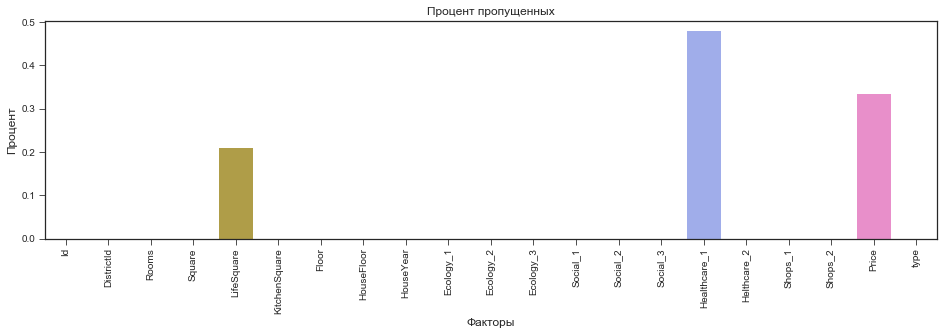

In [44]:
nan_df = (raw_data.isna().sum() / raw_data.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']
plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Процент пропущенных')
plt.ylabel('Процент', fontsize=12)
plt.xlabel('Факторы', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [45]:
raw_data = raw_data.drop('Healthcare_1',axis=1) # сразу удалим, 50% врядли восстановим хоть как-то адекватно.

In [46]:
raw_data.dtypes # есть не числовые типы, надо сразу их перевести в бинари чтобы расшрить информацией лерн для более правильного принятия решения об исключении точек из лерна

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
type              object
dtype: object

In [47]:
raw_data.isnull().sum() # два поля с наличем пустых элементов, с ними разберемя позже

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
type                0
dtype: int64

In [48]:
raw_data.Ecology_2.value_counts() # в категориальной переменной только стринги это хорошо

B    14855
A      145
Name: Ecology_2, dtype: int64

In [49]:
raw_data.Ecology_3.value_counts() # в тут тоже норм

B    14576
A      424
Name: Ecology_3, dtype: int64

In [50]:
raw_data.Shops_2.value_counts() # в тут тоже норм

B    13763
A     1237
Name: Shops_2, dtype: int64

In [51]:
# здесь переведем категориальные переменные в бинарные
bincat_eco2 = pd.get_dummies(raw_data['Ecology_2'])
bincat_eco3 = pd.get_dummies(raw_data['Ecology_3'])
bincat_shops_2 = pd.get_dummies(raw_data['Shops_2'])

raw_data[bincat_eco2.columns] = bincat_eco2
raw_data = raw_data.rename(columns={'A':'A_eco_2', 'B':'B_eco_2'})

raw_data[bincat_eco3.columns] = bincat_eco3
raw_data = raw_data.rename(columns={'A':'A_eco_3', 'B':'B_eco_3'})

raw_data[bincat_shops_2.columns] = bincat_shops_2
raw_data = raw_data.rename(columns={'A':'A_shops_2', 'B':'B_shops_2'}).drop(['Ecology_2','Ecology_3', 'Shops_2'],axis=1)

In [52]:
raw_data.sample(10) #посмотрим рызные квартиры в датафрейме

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
3019   14702         178             4.000000            82.623717            60.541682             7.000000      3             7.000000       1960             0.460556        20      4386        14            1        5       380,689.471264  learn        0        1        0        1          0          1
5840    6308          90             1.000000            41.338458            19.550828             8.000000     15            15.000000       1975             0.265089        37      5288         0            3        2       229,025.093572  learn        0        1        0        1          0          1
2555   13812           1             1.000000            44.004222                  nan             1.000000      9            17.000000       1977             0.007122         1       264         0            0        1       131,509.563628  learn        0        1        0        1          0          1
2989    1304          30             1.000000            42.194570                  nan             1.000000     10             1.000000       1977             0.000078        22      6398       141            3       23       129,198.860342  learn        0        1        0        1          0          1
14150  13074          27             2.000000            63.847595            62.856080             1.000000      4            22.000000       2015             0.211401         9      1892         0            0        1                  nan   test        0        1        0        1          0          1
9080   16209           6             3.000000            77.341477            80.610702             1.000000      7            17.000000       1977             0.243205         5      1564         0            0        0       210,082.735643  learn        0        1        0        1          0          1
4676   16092          62             3.000000            96.009479                  nan             0.000000      4             3.000000       2014             0.072158         2       629         1            0        0       209,637.158007  learn        0        1        0        1          1          0
3125    8374          25             2.000000            75.964402            45.179582            11.000000      2            25.000000       2009             0.069753        53     13670         4            1       11       188,098.047547  learn        0        1        0        1          0          1
6639    4710          11             3.000000            62.546661            42.007038             8.000000      7             9.000000       1972             0.012339        35      5776         1            2        4       230,539.377745  learn        0        1        0        1          0          1
14975   5346          53             4.000000           110.366487            77.705849            20.000000      9            24.000000       2018             0.049637        34      7759         0            1        3                  nan   test        0        1        0        1          0          1

In [53]:
print(len(set(raw_data[raw_data['type']=='learn'].DistrictId)))
print(len(set(raw_data[raw_data['type']=='test'].DistrictId)))
# видим, что есть районы, где нет квартир из обучения, но есть из теста или наборот. Это плохо.

205
201


In [54]:
district_dict_train = set(raw_data[raw_data['type']=='learn']['DistrictId'].unique())
district_dict_test = set(raw_data[raw_data['type']=='test']['DistrictId'].unique())
del_keys = list(district_dict_train.difference(district_dict_test))
del_keys

[162, 195, 133, 199, 201, 202, 174, 207, 50, 117, 158]

In [55]:
raw_data.shape

(15000, 23)

In [56]:
raw_data.sample(5)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
11965   4485          13             1.000000            39.185109            20.403370             8.000000     11            16.000000       2002             0.133215        49     11395         3            3        4                  nan   test        0        1        0        1          1          0
1904    8839          74             2.000000            92.883180                  nan             1.000000     15            22.000000       1977             0.075779         6      1437         3            0        2       284,488.564051  learn        0        1        0        1          0          1
1615   15479          23             1.000000            38.924240                  nan             1.000000      8            12.000000       1977             0.034656         0       168         0            0        0        92,116.942064  learn        0        1        0        1          0          1
6862    4626          64             2.000000            45.493484            32.568879             6.000000      9             9.000000       1971             0.135650        46      7960         6            3       11       217,344.455089  learn        0        1        0        1          0          1
11015   6663           0             2.000000            46.801272            30.871297             5.000000      7             5.000000       1962             0.319809        25      4756        16            5        8                  nan   test        0        1        0        1          0          1

In [57]:
raw_data.to_pickle('raw_data.pkl')

In [58]:
raw_data = pd.read_pickle('raw_data.pkl')

Среднее значение: 214139.0
Медиана: 192270.0
Мода: 59175.0


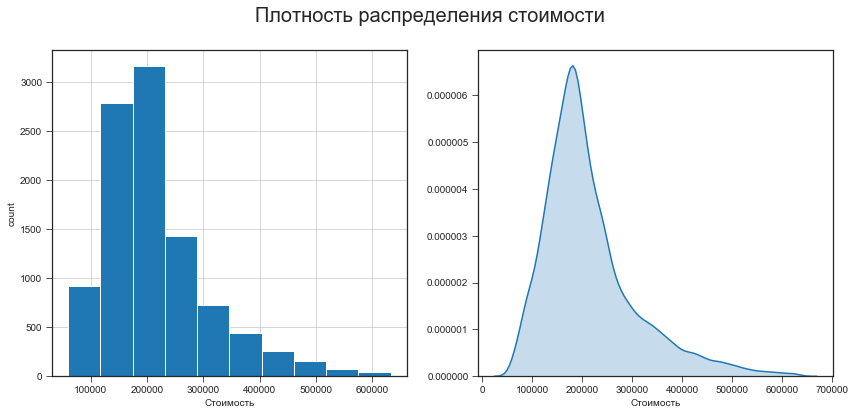

In [60]:
#Видим, что цена похоже имеет логнормальное распределение, будем потом смотреть профиль тестовыйх прогнозов. Профиль должен быть такой же.

plt.figure(figsize = (14, 6))

plt.subplot(121)
raw_train['Price'].hist(edgecolor='white')
plt.ylabel('count')
plt.xlabel('Стоимость')

plt.subplot(122)
sns.kdeplot(raw_train['Price'], shade=True, legend=False)
plt.xlabel('Стоимость')

plt.suptitle('Плотность распределения стоимости', size=20)

target_mean = round(raw_train['Price'].mean(), 2)
target_median = raw_train['Price'].median()
target_mode = raw_train['Price'].mode()[0]

print(f"Среднее значение: {np.round(target_mean,0)}\nМедиана: {np.round(target_median,0)}\nМода: {np.round(target_mode,0)}")

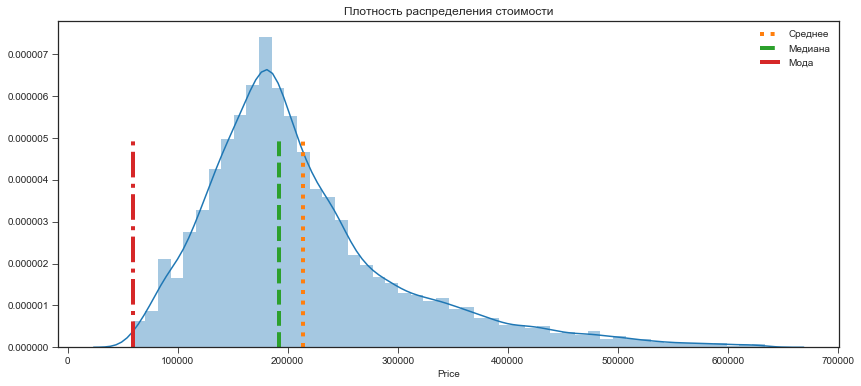

In [61]:
plt.figure(figsize = (14, 6))

sns.distplot(raw_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='Среднее', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='Медиана', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='Мода', linestyle='-.', linewidth=4)

plt.title('Плотность распределения стоимости')
plt.legend()

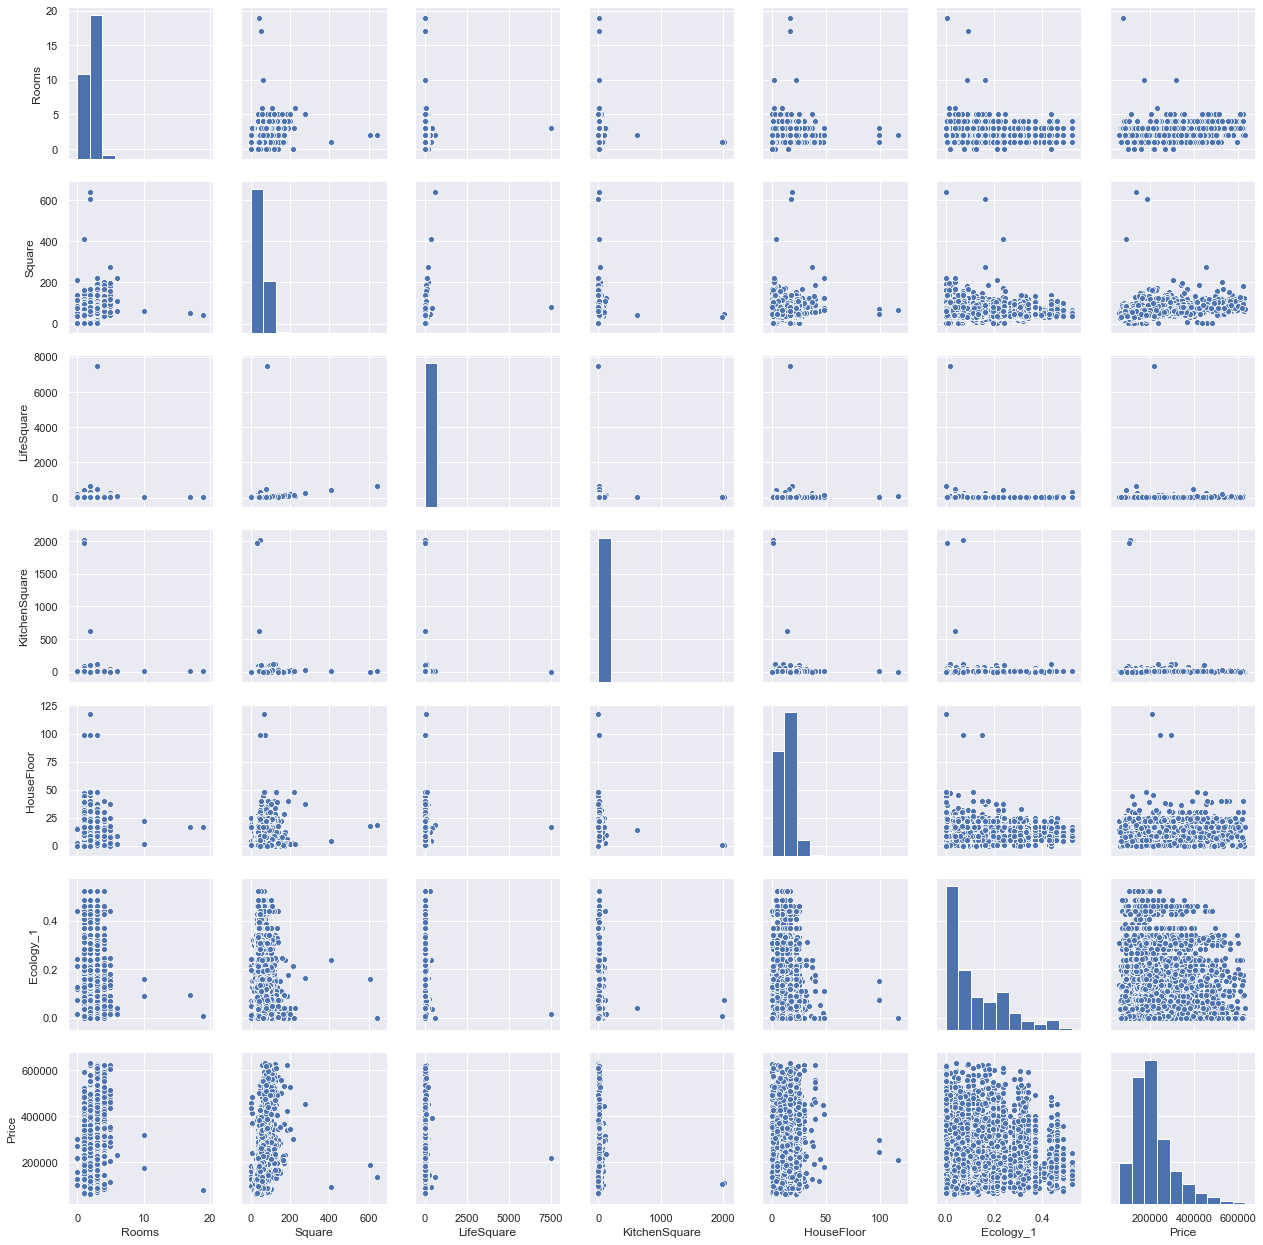

In [46]:
# Смотрим как в целом взаимосвязаны факторы между собой
feature_num_names = raw_data.drop('Price', axis=1).select_dtypes(include='float64').columns.tolist()
sns.set()
sns.pairplot(raw_data[feature_num_names[:6] + ['Price']]);

# Разбор и формирование правил для Rooms

In [62]:
raw_test.Rooms.value_counts() # видим какие квартиры нас интересуют на тесте

 2.000000    2030
 1.000000    1769
 3.000000    1099
 4.000000      90
 5.000000       7
 0.000000       2
 6.000000       2
17.000000       1
Name: Rooms, dtype: int64

In [63]:
raw_train.Rooms.value_counts() # есть странные по количеству комнат квартиры, надо разобрать 11 квартир (0.1% от выборки). Если восстановить не получится, то удалим эти записи из лерна

 2.000000    3880
 1.000000    3705
 3.000000    2235
 4.000000     150
 5.000000      18
 0.000000       8
10.000000       2
19.000000       1
 6.000000       1
Name: Rooms, dtype: int64

In [64]:
df = raw_data[['Rooms', 'Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# Видим, что кореляция 55%, маловато, попробуем поднять

Text(0.5, 1.0, 'Distribution of Price by Rooms')

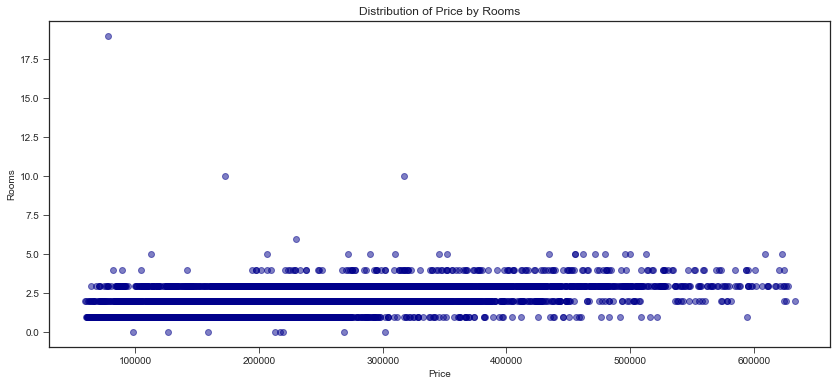

In [65]:
plt.figure(figsize=(14, 6))

plt.scatter(raw_data['Price'], raw_data['Rooms'], alpha=0.5, color='darkblue')

plt.xlabel('Price')
plt.ylabel('Rooms')
plt.title('Distribution of Price by Rooms')

In [66]:
# Глянем на все квартиры с количество комнат больше 6
raw_data[raw_data['Rooms']>=6]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
377     5927          57            10.000000            59.056975            36.223072            10.000000     22            22.000000       2002             0.090799        74     19083         2            5       15       317,265.323792  learn        0        1        0        1          0          1
1454    8491           1            19.000000            42.006046            21.779288             7.000000     17            17.000000       2014             0.007122         1       264         0            0        1        78,364.616704  learn        0        1        0        1          0          1
2170   14003          99             6.000000            59.414334            38.702244             6.000000      7             9.000000       1969             0.033494        66     10573         1            3        8       229,661.964416  learn        0        1        0        1          0          1
8849   14865           9            10.000000            60.871266            38.420681            10.000000      3             2.000000       1994             0.161532        25      5648         1            2        4       172,329.270863  learn        0        1        0        1          0          1
12071  10793          23             6.000000           110.750226                  nan             0.000000      2             2.000000       2015             0.014073         2       475         0            0        0                  nan   test        0        1        0        1          0          1
13217   4058          27             6.000000           223.453689           104.113552            16.000000      2             2.000000       2017             0.041116        53     14892         4            1        4                  nan   test        0        1        0        1          0          1
13398   1435         111            17.000000            52.866107            32.528342             8.000000     15            17.000000       1987             0.093443        23      4635         5            2        4                  nan   test        0        1        0        1          0          1

In [67]:
raw_data.loc[raw_data['Id'].isin([5927,14865,1435,14003]), 'Rooms'] = 3
raw_data.loc[raw_data['Id'].isin([8491]), 'Rooms'] = 2

In [68]:
raw_data[raw_data['Rooms']>=6]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price  type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
12071  10793          23             6.000000           110.750226                  nan             0.000000      2             2.000000       2015             0.014073         2       475         0            0        0                  nan  test        0        1        0        1          0          1
13217   4058          27             6.000000           223.453689           104.113552            16.000000      2             2.000000       2017             0.041116        53     14892         4            1        4                  nan  test        0        1        0        1          0          1

In [69]:
raw_data['Rooms'].value_counts()

2.000000    5911
1.000000    5474
3.000000    3338
4.000000     240
5.000000      25
0.000000      10
6.000000       2
Name: Rooms, dtype: int64

In [70]:
raw_data[raw_data['Rooms']==0].sort_values('Square')

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
4853    3224          27             0.000000             2.377248             0.873147             0.000000      1             0.000000       1977             0.017647         2       469         0            0        0       126,596.941798  learn        0        1        0        1          0          1
6149    3159          88             0.000000            38.697117            19.345131             9.000000      9            16.000000       1982             0.127376        43      8429         3            3        9       158,998.110646  learn        0        1        0        1          0          1
2269    7317          27             0.000000            41.790881                  nan             0.000000     13             0.000000       1977             0.211401         9      1892         0            0        1        98,129.976788  learn        0        1        0        1          0          1
3911     770          28             0.000000            49.483501                  nan             0.000000     16             0.000000       2015             0.118537        30      6207         1            1        0       217,009.338463  learn        0        1        0        1          0          1
12524  10729          27             0.000000            76.345154            42.820796            12.000000     14             0.000000       1977             0.017647         2       469         0            0        0                  nan   test        0        1        0        1          0          1
4366     456           6             0.000000            81.491446                  nan             0.000000      4             0.000000       1977             0.243205         5      1564         0            0        0       212,864.799112  learn        0        1        0        1          0          1
8834    9443          27             0.000000            87.762616            85.125471             0.000000      5            15.000000       1977             0.211401         9      1892         0            0        1       219,281.918007  learn        0        1        0        1          0          1
12406   3343          58             0.000000           116.824201           113.692424             0.000000      3             3.000000       1977             0.437885        23      5735         3            0        5                  nan   test        0        1        0        1          0          1
1397   12638          27             0.000000           138.427694           136.215499             0.000000      4             3.000000       2016             0.075424        11      3097         0            0        0       268,394.744389  learn        0        1        0        1          0          1
1981    7917          27             0.000000           212.932361           211.231125             0.000000      2             3.000000       2008             0.211401         9      1892         0            0        1       302,211.260887  learn        0        1        0        1          0          1

In [71]:
# удалим из обучения сразу те записи (в доле их совсем мало), которые по нескольким измерениям не похожи на правду. Когда жилая площадь практически равна общей площади и т.д.
# bad_households = [3224,9443,12638,7917,7317,770,456,9443]
bad_households = [3224,12638,7917,7317,770,456]
raw_data = raw_data[~raw_data['Id'].isin(bad_households)].reset_index(drop=True)

In [72]:
raw_data.loc[raw_data['Id'].isin([3159]), 'Rooms'] = 1
raw_data.loc[raw_data['Id'].isin([10729,9443]), 'Rooms'] = 3
raw_data.loc[raw_data['Id'].isin([3343]), 'Rooms'] = 4

In [73]:
del_ids = list(raw_data[(raw_data['Rooms']==1) & (raw_data['Price']>500000)]['Id'])
del_ids

[6036, 13603, 7496, 16638]

In [74]:
raw_data.loc[raw_data['Id'].isin(del_ids)]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
896    6036          95             1.000000            46.248238                  nan             0.000000      5             0.000000       1977             0.000699        14      3369        24            0        3       516,315.770611  learn        0        1        0        1          0          1
1917  13603          63             1.000000           127.651237             2.609712             1.000000      8            17.000000       2016             0.238617        26      3889         6            3        6       594,565.299770  learn        0        1        0        1          0          1
8818   7496          30             1.000000           117.370746           102.187199             6.000000     14            40.000000       2011             0.000078        22      6398       141            3       23       521,829.550445  learn        0        1        0        1          0          1
9583  16638          38             1.000000           106.260300           109.246660             1.000000      4             1.000000       1977             0.060753        15      2787         2            0        7       509,162.416594  learn        0        1        0        1          0          1

In [75]:
raw_data = raw_data[~(raw_data['Id'].isin(del_ids))].reset_index(drop=True)

In [76]:
bad_households = [6358,7594]

raw_data.loc[raw_data['Id'].isin([6358,7594])]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
3266  6358          27             5.000000            42.003293                  nan             0.000000      5            12.000000       1977             0.011654         4       915         0            0        0       112,693.641769  learn        0        1        0        1          0          1
4424  7594          53             5.000000            39.906082            39.394024             1.000000      5             1.000000       1977             0.049637        34      7759         0            1        3       206,148.845716  learn        0        1        0        1          0          1

In [77]:
raw_data = raw_data[~raw_data['Id'].isin(bad_households)].reset_index(drop=True)

Text(0.5, 1.0, 'Distribution of Price by Rooms')

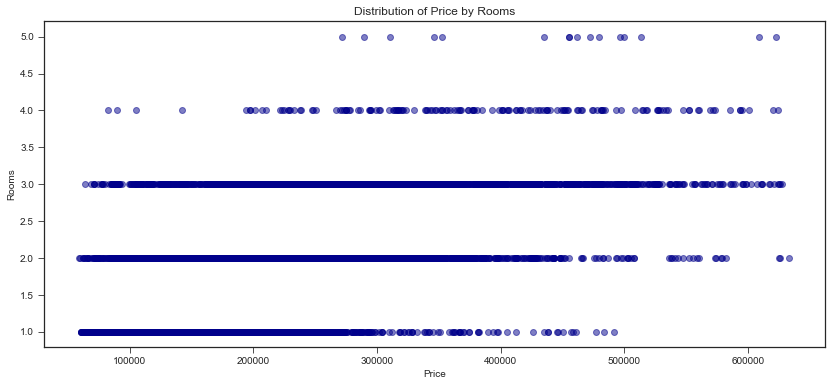

In [78]:
plt.figure(figsize=(14, 6))

plt.scatter(raw_data['Price'], raw_data['Rooms'], alpha=0.5, color='darkblue')

plt.xlabel('Price')
plt.ylabel('Rooms')
plt.title('Distribution of Price by Rooms')

In [79]:
raw_data[raw_data['Rooms']==0]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Social_1, Social_2, Social_3, Helthcare_2, Shops_1, Price, type, A_eco_2, B_eco_2, A_eco_3, B_eco_3, A_shops_2, B_shops_2]
Index: []

In [81]:
df = raw_data[['Rooms', 'Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# Видим, что кореляция стала 58%, немного лучше)

In [82]:
raw_data.type.value_counts()

learn    9988
test     5000
Name: type, dtype: int64

In [83]:
raw_data.Rooms.value_counts()

2.000000    5911
1.000000    5471
3.000000    3340
4.000000     241
5.000000      23
6.000000       2
Name: Rooms, dtype: int64

In [86]:
raw_data.to_pickle('raw_data_2.pkl')

# Разбор и формирование правил для Square и LifeSquare

In [87]:
raw_data = pd.read_pickle('raw_data_2.pkl')

In [88]:
df = raw_data[['LifeSquare', 'Square','KitchenSquare', 'Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# Видим, что кореляция общей и жилой площадей 22%, мало, попробуем поднять. А площадь кухни вообще не связана ни с чем

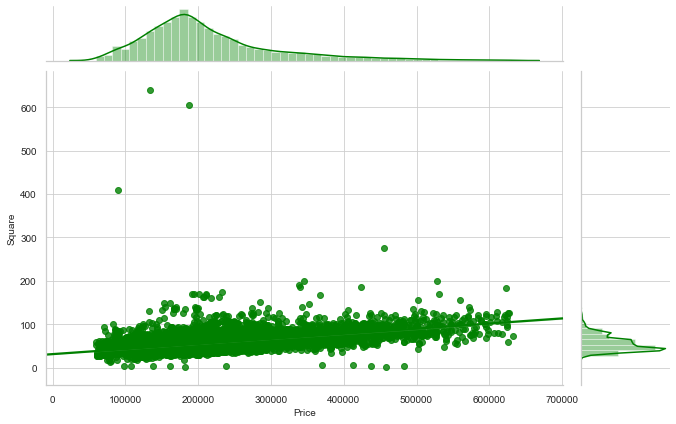

In [89]:
with sns.axes_style(style='whitegrid'):
    grid = sns.jointplot(raw_data['Price'], raw_data['Square'], kind='reg', color='green')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

In [90]:
raw_data.loc[raw_data['Square']>300]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
4255     28           9             2.000000           604.705972                  nan             1.000000     17            18.000000       1977             0.161532        25      5648         1            2        4       187,717.242538  learn        0        1        0        1          0          1
4681   2307         102             1.000000           409.425181           410.639749            10.000000      4             4.000000       2016             0.238617        26      3889         6            3        6        90,470.430830  learn        0        1        0        1          0          1
6967  11602          30             2.000000           641.065193           638.163193            10.000000     20            19.000000       2019             0.000078        22      6398       141            3       23       133,529.681562  learn        0        1        0        1          0          1

In [91]:
raw_data = raw_data[~raw_data['Id'].isin([28,2307,11602])].reset_index(drop=True)

In [92]:
raw_data[(raw_data['Square']<15)].sort_values('Price')

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
4728   12676          81             3.000000            13.784865            15.988889             7.000000      4             5.000000       1960             0.319809        25      4756        16            5        8        78,388.806186  learn        0        1        0        1          0          1
3274   10527          27             1.000000             4.380726            40.805837             1.000000     10            17.000000       2013             0.211401         9      1892         0            0        1        97,560.720383  learn        0        1        0        1          0          1
1315   11526          27             1.000000             4.633498             1.969969             1.000000     18             1.000000       1977             0.011654         4       915         0            0        0       107,604.269441  learn        0        1        0        1          0          1
1606   10202           6             1.000000             2.596351             4.604943             1.000000      3            25.000000       2014             0.243205         5      1564         0            0        0       137,597.601458  learn        0        1        0        1          0          1
4888    4504          27             3.000000             4.390331             5.610772             1.000000      8            19.000000       2016             0.211401         9      1892         0            0        1       161,379.067034  learn        0        1        0        1          0          1
6380   14786           1             1.000000             1.136859             4.525736             1.000000      3             1.000000       1977             0.007122         1       264         0            0        1       181,434.825589  learn        0        1        0        1          0          1
8017   13265           1             3.000000             4.823679            79.767964             0.000000      6            17.000000       1977             0.007122         1       264         0            0        1       237,716.681261  learn        0        1        0        1          0          1
3407    9487           5             1.000000             5.129222             5.549458             1.000000      1             1.000000       1977             0.150818        16      3433         4            4        5       369,472.403061  learn        0        1        0        1          0          1
212     1748          88             2.000000             5.497061            67.628717             1.000000     24            22.000000       1977             0.127376        43      8429         3            3        9       412,511.088764  learn        0        1        0        1          0          1
9280    6782          45             1.000000             2.954309             5.257278             1.000000      3             1.000000       1977             0.195781        23      5212         6            3        2       438,005.182323  learn        0        1        0        1          0          1
8270   15744          34             1.000000             1.988943             2.642219             1.000000     21             4.000000       1977             0.069753        53     13670         4            1       11       458,378.777006  learn        0        1        0        1          0          1
9598    7657          38             1.000000             4.502784             4.618547             1.000000     28             1.000000       1977             0.060753        15      2787         2            0        7       483,283.488083  learn        0        1        0        1          0          1
9987    5480       

In [93]:
raw_data[(raw_data['DistrictId']==190) | (raw_data['HouseYear']==1909)].sort_values('Price')

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
9157   14552         190             2.000000            62.960634                  nan             1.000000      5            20.000000       1977             0.000000        30      7538        87            5        5       193,687.037324  learn        0        1        0        1          0          1
7661   14208         190             2.000000            44.000047            26.903125             6.000000      4            10.000000       1966             0.000000        30      7538        87            5        5       380,765.543594  learn        0        1        0        1          0          1
831     9530         190             3.000000            58.709335            37.330243             6.000000      5             9.000000       1964             0.000000        30      7538        87            5        5       507,552.246997  learn        0        1        0        1          0          1
8150   16018         190             3.000000            76.297535            53.913148             6.000000     10             8.000000       1933             0.000000        30      7538        87            5        5       526,438.458919  learn        0        1        0        1          0          1
2549   10919         190             2.000000            47.489415            35.564479             4.000000      5             5.000000       1918             0.000000        30      7538        87            5        5       537,979.657509  learn        0        1        0        1          0          1
7318   15421         190             3.000000            70.223411            42.703772             8.000000      7            12.000000       1971             0.000000        30      7538        87            5        5       561,876.202527  learn        0        1        0        1          0          1
6445   13470         190             3.000000            67.426461            41.044340             8.000000      9             9.000000       1967             0.000000        30      7538        87            5        5       595,468.077564  learn        0        1        0        1          0          1
9987    5480         190             1.000000            13.597819            15.948246            12.000000      2             5.000000       1909             0.000000        30      7538        87            5        5                  nan   test        0        1        0        1          0          1
10694   7440         190             2.000000            48.185947            33.487835             5.000000      3             9.000000       1966             0.000000        30      7538        87            5        5                  nan   test        0        1        0        1          0          1

In [97]:
import plotly.express as px
px.histogram(raw_data, x='Square')
# выбросы есть

In [95]:
px.histogram(df, x='LifeSquare')
# сильные выбросы есть

In [96]:
px.histogram(df, x='KitchenSquare')
# сильные выбросы есть

In [98]:
raw_data[raw_data['LifeSquare']>300].sort_values('Price')

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
4320   16550          27             3.000000            81.694417         7,480.592129             1.000000      9            17.000000       2016             0.017647         2       469         0            0        0       217,357.492366  learn        0        1        0        1          0          1
8424   15886          85             3.000000            78.059331           461.463614            10.000000     12            16.000000       1998             0.037178        52     11217         1            1        7       394,253.299978  learn        0        1        0        1          0          1
10395  11533          94             2.000000            48.713443           303.071094             6.000000      5            12.000000       1974             0.521867        25      6149         0            0        0                  nan   test        0        1        0        1          0          1

In [99]:
raw_data.loc[raw_data['Id'].isin([11533]), 'LifeSquare'] = 30.3071094
raw_data.loc[raw_data['Id'].isin([15886]), 'LifeSquare'] = 46.1463614
raw_data.loc[raw_data['Id'].isin([16550]), 'LifeSquare'] = 74.8059212

In [100]:
raw_data[raw_data['LifeSquare']>300].sort_values('Price')

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Social_1, Social_2, Social_3, Helthcare_2, Shops_1, Price, type, A_eco_2, B_eco_2, A_eco_3, B_eco_3, A_shops_2, B_shops_2]
Index: []

In [101]:
px.histogram(raw_data, x='LifeSquare')

In [102]:
raw_data.to_pickle('raw_data_3.pkl')

In [103]:
raw_data = pd.read_pickle('raw_data_3.pkl')

In [105]:
raw_data[raw_data['KitchenSquare']>125].sort_values('KitchenSquare')

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
11949  14594          11             2.000000            42.795304            24.223770           620.000000     11            14.000000       1972             0.038693        28      6533         1            2        5                  nan   test        0        1        0        1          0          1
8571   14679          81             1.000000            32.276663            19.278394         1,970.000000      6             1.000000       1977             0.006076        30      5285         0            6        6       105,539.556275  learn        0        1        0        1          0          1
1063   14656          62             1.000000            47.100719            46.447960         2,014.000000      4             1.000000       2014             0.072158         2       629         1            0        0       108,337.484207  learn        0        1        0        1          1          0

In [106]:
raw_data.loc[raw_data['Id'].isin([14594]), 'KitchenSquare'] = 6.0
raw_data.loc[raw_data['Id'].isin([14679]), 'KitchenSquare'] = 6.0
raw_data.loc[raw_data['Id'].isin([14656]), 'KitchenSquare'] = 8

In [107]:
raw_data[raw_data['KitchenSquare']>80].sort_values('type')

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
2911   12390          72             3.000000            97.490674            99.323558            96.000000     22            25.000000       2019             0.210473        11      2398         2            3        0       445,074.956552  learn        0        1        0        1          0          1
2964    7441          62             3.000000           114.734473           112.589083           112.000000      3             3.000000       2015             0.072158         2       629         1            0        0       315,245.521059  learn        0        1        0        1          1          0
4641   12552          58             3.000000           116.405693           113.109653           112.000000      3             3.000000       2016             0.437885        23      5735         3            0        5       296,165.936689  learn        0        1        0        1          0          1
7075    6569          27             1.000000            38.220258            18.716856            84.000000      4            17.000000       2018             0.011654         4       915         0            0        0        99,079.960518  learn        0        1        0        1          0          1
9880    2737          27             3.000000           123.430072           125.806981           123.000000      5            10.000000       2015             0.017647         2       469         0            0        0       234,194.837047  learn        0        1        0        1          0          1
11762   3341          62             3.000000           112.114019           112.247841           112.000000      3             3.000000       2017             0.072158         2       629         1            0        0                  nan   test        0        1        0        1          1          0
14540  12640           6             2.000000            54.629142            31.486308            97.000000      4            17.000000       2015             0.243205         5      1564         0            0        0                  nan   test        0        1        0        1          0          1

In [108]:
raw_data[(raw_data['DistrictId']==6) & (raw_data['Rooms']==2)]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
74      4014           6             2.000000            63.184422            61.142894             1.000000     17            17.000000       2016             0.243205         5      1564         0            0        0       190,762.981550  learn        0        1        0        1          0          1
134    12613           6             2.000000            65.496674             5.589324             1.000000      5            17.000000       1977             0.243205         5      1564         0            0        0       180,727.643541  learn        0        1        0        1          0          1
174     2347           6             2.000000            67.170587                  nan             1.000000     11            17.000000       1977             0.243205         5      1564         0            0        0       192,944.379324  learn        0        1        0        1          0          1
208    11535           6             2.000000            56.571290            34.538703             9.000000     14            17.000000       2011             0.243205         5      1564         0            0        0       101,123.733066  learn        0        1        0        1          0          1
320    11173           6             2.000000            62.648779                  nan             0.000000      6            17.000000       1977             0.243205         5      1564         0            0        0       182,625.548872  learn        0        1        0        1          0          1
327     1008           6             2.000000            56.183673            35.419148             8.000000      8            17.000000       2013             0.243205         5      1564         0            0        0       167,203.801254  learn        0        1        0        1          0          1
421     3928           6             2.000000            68.708140            64.138062             1.000000     12            17.000000       2017             0.243205         5      1564         0            0        0       188,805.693293  learn        0        1        0        1          0          1
560     8149           6             2.000000            71.904226             4.171094             1.000000      9            25.000000       2015             0.243205         5      1564         0            0        0       184,050.456761  learn        0        1        0        1          0          1
631     4857           6             2.000000            63.047343            41.079923            10.000000      6            25.000000       2016             0.243205         5      1564         0            0        0       171,909.534948  learn        0        1        0        1          0          1
664    14553           6             2.000000            67.972296            64.712021            10.000000     15            17.000000       2018             0.243205         5      1564         0            0        0       189,382.650276  learn        0        1        0        1          0          1
780    12850           6             2.000000            65.340375                  nan             1.000000     14            17.000000       1977             0.243205         5      1564         0            0        0       166,300.365077  learn        0        1        0        1          0          1
785     3290           6             2.000000            64.416586                  nan             1.000000     12             1.000000       1977             0.243205         5      1564         0            0        0       176,682.487067  learn        0        1        0        1          0          1
786    14808       

In [109]:
raw_data.loc[raw_data['Id'].isin([3341]), 'KitchenSquare'] = 11.0
raw_data.loc[raw_data['Id'].isin([12640]), 'KitchenSquare'] = 9

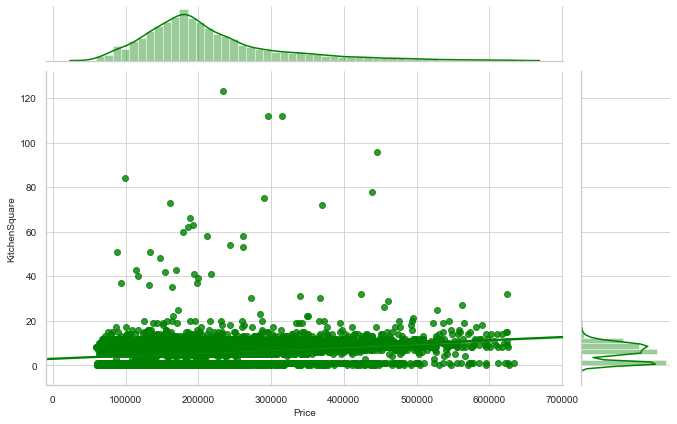

In [110]:
with sns.axes_style(style='whitegrid'):
    grid = sns.jointplot(raw_data['Price'], raw_data['KitchenSquare'], kind='reg', color='green')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

In [114]:
raw_data.to_pickle('raw_data_4.pkl')

In [262]:
raw_data = pd.read_pickle('raw_data_4.pkl')

In [263]:
raw_data.sample(6)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2
13401   9553           1             1.000000            50.788378                  nan             0.000000     17            24.000000       1977             0.007122         1       264         0            0        1                  nan   test        0        1        0        1          0          1
11983   9919          29             2.000000            48.477259            30.380180             6.000000      2             5.000000       1963             0.069660        31      6119         4            1        2                  nan   test        0        1        0        1          0          1
3788     523         101             1.000000            18.509177            15.170851             3.000000      5             5.000000       1970             0.225825        41      6558         7            3        2       115,845.861527  learn        1        0        0        1          0          1
12156   5160          58             3.000000            93.756285                  nan             1.000000      2             3.000000       1977             0.437885        23      5735         3            0        5                  nan   test        0        1        0        1          0          1
3227   16147          90             2.000000            58.889173            36.416307             9.000000      4            17.000000       1989             0.246032        22      3151         4            3        3       217,401.331324  learn        0        1        1        0          0          1
10096   3420           9             1.000000            38.395665            17.331543             8.000000     11            14.000000       2010             0.310199        11      2748         1            0        0                  nan   test        0        1        0        1          0          1

In [264]:
raw_data.loc[raw_data['Id'].isin([170]), 'Square'] = 65

In [265]:
raw_data['LifeSquare_on_Square'] = round(raw_data['LifeSquare'] / raw_data['Square']*100,0)
raw_data[(raw_data['LifeSquare_on_Square']>85) & (raw_data['type']=='test')].sort_values('LifeSquare_on_Square',ascending=False ).head(10)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price  type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
10593  16401          30             1.000000             2.645046             4.338755             1.000000      2             1.000000       1977             0.000078        22      6398       141            3       23                  nan  test        0        1        0        1          0          1            164.000000
14887   1420          45             1.000000             1.975769             2.900371             1.000000      1             1.000000       1977             0.195781        23      5212         6            3        2                  nan  test        0        1        0        1          0          1            147.000000
9987    5480         190             1.000000            13.597819            15.948246            12.000000      2             5.000000       1909             0.000000        30      7538        87            5        5                  nan  test        0        1        0        1          0          1            117.000000
11935   7031           6             1.000000            37.239722            41.385676             0.000000     16             0.000000       1977             0.243205         5      1564         0            0        0                  nan  test        0        1        0        1          0          1            111.000000
13747   6000          23             1.000000            31.308243            34.855604             1.000000      2            17.000000       2017             0.034656         0       168         0            0        0                  nan  test        0        1        0        1          0          1            111.000000
13294   8516           6             1.000000            38.278453            42.655813             1.000000     18            17.000000       2016             0.243205         5      1564         0            0        0                  nan  test        0        1        0        1          0          1            111.000000
14764   5152          23             1.000000            36.330427            39.790094             0.000000      6             4.000000       1977             0.034656         0       168         0            0        0                  nan  test        0        1        0        1          0          1            110.000000
13998  10011          81             1.000000            31.442874            34.464005             5.000000      4             5.000000       1966             0.319809        25      4756        16            5        8                  nan  test        0        1        0        1          0          1            110.000000
10904    310          27             3.000000            45.411358            49.883368             0.000000     18            25.000000       1977             0.072158         2       629         1            0        0                  nan  test        0        1        0        1          1          0            110.000000
11820  10228          27             1.000000            37.142672            40.830384             1.000000      3            15.000000       2014             0.211401         9      1892         0            0        1                  nan  test        0        1        0        1          0          1            110.000000

In [266]:
raw_data[(raw_data['type']=='test') & (raw_data['LifeSquare_on_Square']>112)]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price  type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
9987    5480         190             1.000000            13.597819            15.948246            12.000000      2             5.000000       1909             0.000000        30      7538        87            5        5                  nan  test        0        1        0        1          0          1            117.000000
10593  16401          30             1.000000             2.645046             4.338755             1.000000      2             1.000000       1977             0.000078        22      6398       141            3       23                  nan  test        0        1        0        1          0          1            164.000000
14887   1420          45             1.000000             1.975769             2.900371             1.000000      1             1.000000       1977             0.195781        23      5212         6            3        2                  nan  test        0        1        0        1          0          1            147.000000

In [267]:
raw_data.loc[raw_data['Id'].isin([1748]), 'Square'] = 67.628717
raw_data.loc[raw_data['Id'].isin([1748]), 'LifeSquare'] = 54.97061
raw_data.loc[raw_data['Id'].isin([14990]), 'LifeSquare'] = 26.3542020
raw_data.loc[raw_data['Id'].isin([8961]), 'LifeSquare'] = 16.4153360
raw_data.loc[raw_data['Id'].isin([13265]), 'LifeSquare'] = 48.23679
raw_data.loc[raw_data['Id'].isin([13265]), 'Square'] = 79.767964
raw_data.loc[raw_data['Id'].isin([10527]), 'Square'] = 43.80726

In [268]:
raw_data['LifeSquare_on_Square'] = round(raw_data['LifeSquare'] / raw_data['Square']*100,0)

In [269]:
raw_data[raw_data['LifeSquare_on_Square']>112]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor  HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
1606   10202           6             1.000000             2.596351             4.604943             1.000000      3            25.000000       2014             0.243205         5      1564         0            0        0       137,597.601458  learn        0        1        0        1          0          1            177.000000
3161   15127         150             1.000000            17.046188            20.036232             8.000000      7            12.000000       1982             0.300323        52     10311         6            1        9        74,222.110465  learn        0        1        0        1          0          1            118.000000
4728   12676          81             3.000000            13.784865            15.988889             7.000000      4             5.000000       1960             0.319809        25      4756        16            5        8        78,388.806186  learn        0        1        0        1          0          1            116.000000
4888    4504          27             3.000000             4.390331             5.610772             1.000000      8            19.000000       2016             0.211401         9      1892         0            0        1       161,379.067034  learn        0        1        0        1          0          1            128.000000
6029   13875          20             1.000000            28.438794            32.514021             6.000000      6            10.000000       2014             0.019509        37      7687        11            5        5       199,248.114376  learn        0        1        0        1          0          1            114.000000
6380   14786           1             1.000000             1.136859             4.525736             1.000000      3             1.000000       1977             0.007122         1       264         0            0        1       181,434.825589  learn        0        1        0        1          0          1            398.000000
8270   15744          34             1.000000             1.988943             2.642219             1.000000     21             4.000000       1977             0.069753        53     13670         4            1       11       458,378.777006  learn        0        1        0        1          0          1            133.000000
9280    6782          45             1.000000             2.954309             5.257278             1.000000      3             1.000000       1977             0.195781        23      5212         6            3        2       438,005.182323  learn        0        1        0        1          0          1            178.000000
9987    5480         190             1.000000            13.597819            15.948246            12.000000      2             5.000000       1909             0.000000        30      7538        87            5        5                  nan   test        0        1        0        1          0          1            117.000000
10593  16401          30             1.000000             2.645046             4.338755             1.000000      2             1.000000       1977             0.000078        22      6398       141            3       23                  nan   test        0        1        0        1          0          1            164.000000
14887   1420          45             1.000000             1.975769             2.900371             1.000000      1             1.000000       1977             0.195781        23      5212         6            3        2                  nan   test        0        1        0        1          0          1            147.000000

In [270]:
px.histogram(raw_data[raw_data['type']=='learn'], x='LifeSquare_on_Square')

In [271]:
px.histogram(raw_data[raw_data['type']=='test'], x='LifeSquare') # не похожи распределения в тесте и лерне по жилой площади. Это плохо.

In [272]:
# проверим, что мы не потеряли много и что тест целый 
print(raw_data[raw_data['type']=='learn'].shape)
print(raw_data[raw_data['type']=='test'].shape)

(9985, 24)
(5000, 24)


In [273]:
raw_data.shape

(14985, 24)

In [274]:
raw_data.loc[raw_data['LifeSquare'].isna(), 'LifeSquare'] = raw_data['Square'] - raw_data['KitchenSquare']

In [275]:
df = raw_data[['LifeSquare', 'Square','KitchenSquare', 'Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# видим, что стало получше

In [276]:
raw_data.to_pickle('raw_data_5.pkl')

# Здесь разбираемся с годом постройки и этажами

In [277]:
raw_data = pd.read_pickle('raw_data_5.pkl')

In [278]:
df = raw_data[['HouseYear', 'HouseFloor','Floor', 'Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [279]:
raw_data.HouseYear.describe() # выбросы

count          14,985.000000
mean            3,322.903504
std           163,789.695789
min             1,908.000000
25%             1,974.000000
50%             1,977.000000
75%             2,001.000000
max        20,052,011.000000
Name: HouseYear, dtype: float64

In [280]:
raw_data.loc[raw_data['HouseYear']==20052011, 'HouseYear'] = 2011

In [281]:
raw_data.loc[raw_data['HouseYear']==4968, 'HouseYear'] = np.quantile(raw_data[raw_data['DistrictId']==147]['HouseYear'], 0.5)

In [282]:
raw_data.HouseYear.describe() # стало лучше

count          14,985.000000
mean            1,984.698665
std                18.463815
min             1,908.000000
25%             1,973.000000
50%             1,977.000000
75%             2,001.000000
max             2,020.000000
Name: HouseYear, dtype: float64

In [283]:
px.histogram(raw_data[raw_data['type']=='learn'], x='HouseYear')

In [284]:
px.histogram(raw_data[raw_data['type']=='test'], x='HouseYear') # расределения в тесте и лерне похожи. Это хорошо.

In [285]:
raw_data.to_pickle('raw_data_6.pkl')

In [286]:
raw_data = pd.read_pickle('raw_data_6.pkl')

In [287]:
px.histogram(raw_data[raw_data['type']=='test'], x='HouseFloor')
# видим выбросы

In [288]:
raw_data.HouseFloor.describe()

count          14,985.000000
mean               12.611345
std                 6.772909
min                 0.000000
25%                 9.000000
50%                12.000000
75%                17.000000
max               117.000000
Name: HouseFloor, dtype: float64

In [289]:
raw_data[raw_data['HouseFloor']>50] # посмотрим на квартиры в домах больше 50 этажей

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor            HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
6119   10806           5             1.000000            51.944587            48.709601             1.000000      6            99.000000         1,977.000000             0.150818        16      3433         4            4        5       296,127.115515  learn        0        1        0        1          0          1             94.000000
8586    9300          74             2.000000            71.747869            74.579809             9.000000      5            99.000000         1,977.000000             0.075779         6      1437         3            0        2       243,329.912579  learn        0        1        0        1          0          1            104.000000
8840      78          30             2.000000            65.773749            66.811789             1.000000      8           117.000000         1,977.000000             0.000078        22      6398       141            3       23       207,248.370520  learn        0        1        0        1          0          1            102.000000
10636  15864          27             3.000000            47.722835            47.098813             9.000000     18            99.000000         1,977.000000             0.072158         2       629         1            0        0                  nan   test        0        1        0        1          1          0             99.000000

In [290]:
# приведем к соответсвующим медианам по районам
raw_data.loc[raw_data['Id']==78, 'HouseFloor'] = np.quantile(raw_data[raw_data['DistrictId']==30]['HouseFloor'],0.5)
raw_data.loc[raw_data['Id']==10806, 'HouseFloor'] = np.quantile(raw_data[raw_data['DistrictId']==5]['HouseFloor'],0.5)
raw_data.loc[raw_data['Id']==9300, 'HouseFloor'] = np.quantile(raw_data[raw_data['DistrictId']==74]['HouseFloor'],0.5)
raw_data.loc[raw_data['Id']==15864, 'HouseFloor'] = 18

In [291]:
raw_data.HouseFloor.describe() # стало лучше

count          14,985.000000
mean               12.587788
std                 6.607245
min                 0.000000
25%                 9.000000
50%                12.000000
75%                17.000000
max                48.000000
Name: HouseFloor, dtype: float64

In [292]:
raw_data[raw_data['Floor']>50]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor            HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price  type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
14683  15759          17             2.000000            57.601870            37.744743            10.000000     78            22.000000         1,989.000000             0.000000        25      5027         4            1        1                  nan  test        0        1        0        1          0          1             66.000000

In [293]:
raw_data.loc[raw_data['Id']==15759, 'Floor'] = 22

In [294]:
df = raw_data[['HouseYear', 'HouseFloor','Floor', 'Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# здесь скорее не стоит ожидать, что будет хорошая связь с ценой, потому что этаж дорогой где-то посередине дома, и есть старые дома, но очень дорогие

In [295]:
raw_data[raw_data['Floor']>29].sort_values('Price')

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor            HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
339    11563           8             1.000000            50.390862            41.642898             0.000000     32            32.000000         2,008.000000             0.092291        21      4346         2            1        2        97,480.845791  learn        0        1        0        1          0          1             83.000000
4315    6589          30             1.000000            62.110823            52.812128             4.000000     31            44.000000         2,009.000000             0.000078        22      6398       141            3       23       117,647.461002  learn        0        1        0        1          0          1             85.000000
6743    8296         146             1.000000            86.386754            71.904999             0.000000     37            38.000000         2,012.000000             0.236108        16      3893        27            3       10       269,113.584248  learn        0        1        0        1          0          1             83.000000
8344    8016          31             1.000000            59.519896            24.050533            10.000000     33            40.000000         1,977.000000             0.151346        32      5889        10            4        1       389,554.063540  learn        0        1        1        0          0          1             40.000000
3324    3298          31             1.000000            57.551691            21.551876            10.000000     32            40.000000         1,977.000000             0.151346        32      5889        10            4        1       393,799.531732  learn        0        1        1        0          0          1             37.000000
2776    1674          76             2.000000            74.344672            41.044132             5.000000     42            48.000000         2,016.000000             0.000000         7      1660        39            1        5       411,691.504766  learn        0        1        0        1          0          1             55.000000
11572   5707          76             2.000000            73.363523            38.740060             5.000000     38            48.000000         2,010.000000             0.000000         7      1660        39            1        5                  nan   test        0        1        0        1          0          1             53.000000
13570   4533          31             2.000000            83.963299            38.419224            14.000000     33            40.000000         2,014.000000             0.151346        32      5889        10            4        1                  nan   test        0        1        1        0          0          1             46.000000
13696    414          76             2.000000            67.609808            41.175948             5.000000     46            48.000000         2,002.000000             0.000000         7      1660        39            1        5                  nan   test        0        1        0        1          0          1             61.000000
13894   1397          76             3.000000           221.138768           118.055342             4.000000     32            48.000000         2,011.000000             0.000000         7      1660        39            1        5                  nan   test        0        1        0        1          0          1             53.000000
14177  13970           8             1.000000            49.806976            45.910825             1.000000     32            32.000000         2,009.000000             0.092291        21      4346         2            1        2                  nan   test        0        1     

In [296]:
raw_data.Floor.describe()

count          14,985.000000
mean                8.558492
std                 5.293287
min                 1.000000
25%                 4.000000
50%                 7.000000
75%                12.000000
max                46.000000
Name: Floor, dtype: float64

In [297]:
raw_data[raw_data['HouseFloor']==0].shape # почти 400 домов с 0 этажностью. Это плохо.

(395, 24)

In [298]:
raw_data.to_pickle('raw_data_7.pkl')

In [299]:
raw_data = pd.read_pickle('raw_data_7.pkl')

In [300]:
df = pd.DataFrame([])
err_ids = []
for i, group in raw_data.groupby(['DistrictId','HouseYear']): 
    if np.sum(group['HouseYear']) > 0: 
        try:
            qaunt_e1 = np.quantile(group[group['HouseFloor']>1][['HouseFloor']],0.5)
            group.loc[(group['HouseFloor'] == 0) | (group['HouseFloor'].isna()), 'HouseFloor'] = qaunt_e1
        except:
            err_ids.append(group['Id'])
    else:
        pass
    df = pd.concat([df, group], sort=False)
raw_data = df.copy()
print(err_ids)

[3697    2617
Name: Id, dtype: int64, 2138    15261
Name: Id, dtype: int64, 9813    13630
Name: Id, dtype: int64, 13082    9322
Name: Id, dtype: int64, 6291    9030
Name: Id, dtype: int64, 8146    3903
Name: Id, dtype: int64, 4904    4450
Name: Id, dtype: int64, 527    2141
Name: Id, dtype: int64, 11320    3390
Name: Id, dtype: int64, 6723    12191
Name: Id, dtype: int64, 11489    1691
Name: Id, dtype: int64, 7391    4773
Name: Id, dtype: int64, 1103    3217
Name: Id, dtype: int64, 7326    16270
Name: Id, dtype: int64, 10056    9205
Name: Id, dtype: int64, 3846    3456
Name: Id, dtype: int64, 12519    15077
Name: Id, dtype: int64, 13754    4097
Name: Id, dtype: int64, 8583    6038
Name: Id, dtype: int64, 2564    6837
Name: Id, dtype: int64, 2910    6348
Name: Id, dtype: int64, 5003    11578
Name: Id, dtype: int64, 5356    15597
Name: Id, dtype: int64]


In [301]:
raw_data[raw_data['HouseFloor']==0]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor            HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
8583  6038         138             2.000000            73.738049            74.784769             0.000000      6             0.000000         2,018.000000             0.195781        23      5212         6            3        2       372,318.038349  learn        0        1        0        1          0          1            101.000000
2564  6837         165             1.000000            40.781752            19.251596             0.000000      9             0.000000         1,977.000000             0.020741        24      5613         5            2        5       131,026.307065  learn        0        1        0        1          0          1             47.000000
2910  6348         168             1.000000            46.868227            46.868227             0.000000      9             0.000000         1,977.000000             0.341072        27      5664        48            3       11       183,431.410161  learn        0        1        0        1          0          1                   nan

In [302]:
raw_data.loc[(raw_data['HouseFloor']==0) & (raw_data['DistrictId']==138), 'HouseFloor'] = np.quantile(raw_data[raw_data['DistrictId']==138]['HouseFloor'], 0.5)
raw_data.loc[(raw_data['HouseFloor']==0) & (raw_data['DistrictId']==165), 'HouseFloor'] = np.quantile(raw_data[raw_data['DistrictId']==165]['HouseFloor'], 0.5)
raw_data.loc[(raw_data['HouseFloor']==0) & (raw_data['DistrictId']==168), 'HouseFloor'] = np.quantile(raw_data[raw_data['DistrictId']==168]['HouseFloor'], 0.5)

In [303]:
raw_data[raw_data['HouseFloor']==0].shape

(0, 24)

In [304]:
px.histogram(raw_data, x='HouseFloor', log_y=True )

In [305]:
px.histogram(raw_data, x='Floor', log_y=True )

In [306]:
raw_data.loc[(raw_data['HouseFloor'] - raw_data['Floor'] < 0) & (raw_data['HouseFloor'] != 0) & (raw_data['Floor'] != 0)& (raw_data['type'] == 'learn')]

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare  Floor           HouseFloor            HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
1889  13685           0             1.000000            17.498542            13.446544             0.000000      7             5.000000         1,961.000000             0.319809        25      4756        16            5        8        88,871.750230  learn        0        1        0        1          0          1             77.000000
9944  10361           0             1.000000            32.416925            19.257869             6.000000      6             5.000000         1,963.000000             0.319809        25      4756        16            5        8       125,579.315184  learn        0        1        0        1          0          1             59.000000
5565   7797           0             2.000000            43.337904            27.169920             5.000000      6             5.000000         1,964.000000             0.319809        25      4756        16            5        8       176,210.812334  learn        0        1        0        1          0          1             63.000000
7548   3789           0             1.000000            36.765160            22.094905             5.000000     10             9.000000         1,964.000000             0.319809        25      4756        16            5        8       155,874.882994  learn        0        1        0        1          0          1             60.000000
6597  13491           0             1.000000            38.178277             0.370619             0.000000     19            17.000000         2,016.000000             0.006076        30      5285         0            6        6       105,134.286994  learn        0        1        0        1          0          1              1.000000
...     ...         ...                  ...                  ...                  ...                  ...    ...                  ...                  ...                  ...       ...       ...       ...          ...      ...                  ...    ...      ...      ...      ...      ...        ...        ...                   ...
1665   3656         192             1.000000            35.638404            24.736845             5.000000     11             9.000000         1,965.000000             0.225825        41      6558         7            3        2       137,505.343314  learn        1        0        0        1          0          1             69.000000
7183   4588         194             2.000000            38.299961            26.034386             7.000000     11             9.000000         1,962.000000             0.174739        17      3379         9            0        3       222,008.689857  learn        0        1        0        1          0          1             68.000000
35     6486         200             3.000000            85.280389            58.447967             9.000000      6             5.000000         1,960.000000             0.000000        33      7425         1            2        5       402,871.916317  learn        0        1        0        1          0          1             69.000000
1209  16060         208             2.000000            54.600295            32.859246             8.000000     10             9.000000         1,957.000000             0.081943        20      2738        20            1        4       433,346.419160  learn        0        1        0        1          0          1             60.000000
7637  11911         209             1.000000            33.533077            18.101125             5.000000      7             5.000000         1,965.000000             0.040243        25      3478        11            3        1       140,048.802277  learn        0        1        0       

In [307]:
raw_data.loc[raw_data['HouseFloor'] - raw_data['Floor'] < 0, 'Floor'], raw_data.loc[raw_data['HouseFloor'] - raw_data['Floor'] < 0, 'HouseFloor'] = raw_data['HouseFloor'], raw_data['Floor'] # везде где этаж больше максимального в доме приведем к максимальному

In [308]:
df = raw_data[['HouseYear', 'HouseFloor','Floor', 'Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [309]:
raw_data.to_pickle('raw_data_8.pkl')

# Здесь разбираемся с экологическими и социальными признаками

In [310]:
raw_data = pd.read_pickle('raw_data_8.pkl')
raw_data.sample(10)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare                Floor           HouseFloor            HouseYear            Ecology_1  Social_1  Social_2  Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
10003   3495          27             3.000000            82.652818             5.690155             1.000000             4.000000            17.000000         2,015.000000             0.072158         2       629         1            0        0                  nan   test        0        1        0        1          1          0              7.000000
1950    3585         110             2.000000            55.681776            32.434452             8.000000            12.000000            12.000000         1,995.000000             0.033494        66     10573         1            3        8       223,528.982580  learn        0        1        0        1          0          1             58.000000
10175   3804          13             1.000000            42.088254            24.351504             8.000000            11.000000            14.000000         1,997.000000             0.090799        74     19083         2            5       15                  nan   test        0        1        0        1          0          1             58.000000
6247    9548          21             3.000000            79.315685            47.776432            12.000000             6.000000            14.000000         2,009.000000             0.034331        25      5487         3            0        4       198,640.033424  learn        0        1        0        1          0          1             60.000000
4784   14657          62             3.000000           104.019566           103.019566             1.000000             3.000000            17.000000         1,977.000000             0.072158         2       629         1            0        0       240,769.999083  learn        0        1        0        1          1          0                   nan
8825    1301          10             2.000000            51.166303            34.960609             8.000000            12.000000            17.000000         1,988.000000             0.089040        33      7976         5            0       11       269,402.396457  learn        0        1        0        1          0          1             68.000000
4315    6589          30             1.000000            62.110823            52.812128             4.000000            31.000000            44.000000         2,009.000000             0.000078        22      6398       141            3       23       117,647.461002  learn        0        1        0        1          0          1             85.000000
13448   3172          27             3.000000            59.433984            58.951356             1.000000             7.000000            25.000000         2,016.000000             0.072158         2       629         1            0        0                  nan   test        0        1        0        1          1          0             99.000000
8158    6652           7             2.000000            66.868858            36.753726            12.000000            11.000000            17.000000         2,008.000000             0.035145        42      9292         3            0        3       376,628.677623  learn        0        1        0        1          0          1             55.000000
14264  13225          88             1.000000            43.720394            43.720394             0.000000            17.000000            17.000000         1,977.000000             0.127376        43      8429         3            3        9                  nan   test        0        1        0        1          0          1                   nan

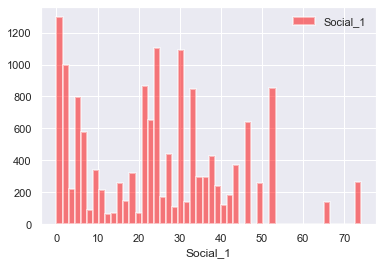

In [311]:
plt.hist(raw_data['Social_1'], bins=50, label="Social_1", alpha=0.5, linewidth=2, color='red')
# plt.xlim(0, 0.55)
plt.legend()
plt.xlabel('Social_1')
plt.show()
# много нулей. Заменим их медианой по каждому району по каждому признаку

In [312]:
print(raw_data[(raw_data['Ecology_1']==0) | (raw_data['Ecology_1'].isna())].shape)
print(raw_data[(raw_data['Social_1']==0) | (raw_data['Social_1'].isna())].shape)
print(raw_data[(raw_data['Social_2']==0) | (raw_data['Social_2'].isna())].shape)
print(raw_data[(raw_data['Social_3']==0) | (raw_data['Social_3'].isna())].shape)

(816, 24)
(301, 24)
(0, 24)
(4460, 24)


In [313]:
def calc_quantile(df_source, column):
    df = pd.DataFrame([])
    for i, group in df_source.groupby('DistrictId'):    
        if sum(group[column]) > 0:
            qaunt_e1 = np.quantile(group[group[column]>0][column],0.5)
            group.loc[group[column]==0, column] = qaunt_e1
        else:
            group.loc[group[column]==0, column] = 0
        df = pd.concat([df,group], sort=False)
    return df

In [314]:
for i in ['Social_1','Social_2','Social_3','Ecology_1']:
    raw_data = calc_quantile(raw_data, i)

In [315]:
print(raw_data[raw_data['Ecology_1']==0].shape)
print(raw_data[raw_data['Social_1']==0].shape)
print(raw_data[raw_data['Social_2']==0].shape)
print(raw_data[raw_data['Social_3']==0].shape)
# стало заметно меньше нулей

(218, 24)
(0, 24)
(0, 24)
(1108, 24)


In [316]:
df = raw_data[['Ecology_1', 'Social_1','Social_2', 'Social_3','Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [317]:
raw_data = raw_data.drop('Social_2', axis=1) # поправим мультиколлениарность

In [318]:
raw_data.to_pickle('raw_data_9.pkl')

# Здесь разбираемся с показателями здоровья

In [319]:
raw_data = pd.read_pickle('raw_data_9.pkl')
raw_data.sample(10)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare                Floor           HouseFloor            HouseYear            Ecology_1             Social_1             Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square
1547    7097          69             3.000000            73.005028            43.393062            10.000000            12.000000            16.000000         1,982.000000             0.000991            33.000000             3.000000            1        9       387,148.913440  learn        0        1        0        1          0          1             59.000000
11712    555           7             4.000000            74.959758            74.030723             6.000000             5.000000            16.000000         1,972.000000             0.130618            39.000000             9.000000            1        9                  nan   test        0        1        0        1          0          1             99.000000
5915    5537          10             3.000000            90.981595            89.981595             1.000000            22.000000            22.000000         2,013.000000             0.089040            33.000000             5.000000            0       11       376,445.573336  learn        0        1        0        1          0          1                   nan
6939    8240          30             2.000000            62.338541            61.338541             1.000000            13.000000            17.000000         1,977.000000             0.000078            22.000000           141.000000            3       23       215,177.778174  learn        0        1        0        1          0          1                   nan
11140  13195           6             3.000000            80.522754            79.522754             1.000000            15.000000            17.000000         1,977.000000             0.243205             5.000000             0.000000            0        0                  nan   test        0        1        0        1          0          1                   nan
2198    5449           9             3.000000            76.883992            49.277304            10.000000            16.000000            17.000000         1,994.000000             0.161532            25.000000             1.000000            2        4       275,717.980936  learn        0        1        0        1          0          1             64.000000
14277   4867           1             2.000000            71.410140            38.440216             9.000000             9.000000            25.000000         2,016.000000             0.007122             1.000000             1.000000            0        1                  nan   test        0        1        0        1          0          1             54.000000
4879   12936         129             2.000000            63.997877            37.124463             7.000000             5.000000             5.000000         1,963.000000             0.020741            24.000000             5.000000            2        5       286,137.554034  learn        0        1        0        1          0          1             58.000000
1067   10530         167             3.000000            55.629330            36.387124             5.000000             5.000000             5.000000         1,960.000000             0.050272            21.000000            14.000000            0        3       308,416.278807  learn        0        1        0        1          0          1             65.000000
5461   14243          79             3.000000            66.004624            47.899899             9.000000             3.000000            12.000000         1,970.000000             0.307467            30.000000             9.000000            2        5       328,458.653760  learn        0        1        1        0          0          1             73.00

In [320]:
raw_data[['Helthcare_2']].describe().T

count                 mean                  std                  min                  25%                  50%                  75%                  max
Helthcare_2        14,985.000000             1.319720             1.489177             0.000000             0.000000             1.000000             2.000000             6.000000

In [321]:
raw_data[['Helthcare_2']].isna().sum()

Helthcare_2    0
dtype: int64

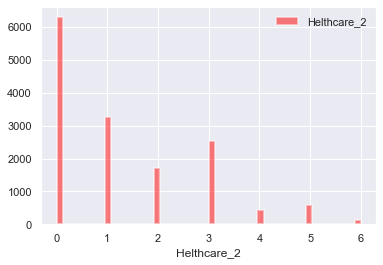

In [322]:
plt.hist(raw_data['Helthcare_2'], bins=50, label="Helthcare_2", alpha=0.5, linewidth=2, color='red')
# plt.xlim(0, 0.55)
plt.legend()
plt.xlabel('Helthcare_2')
plt.show()
# видим, что признак похож на категорию

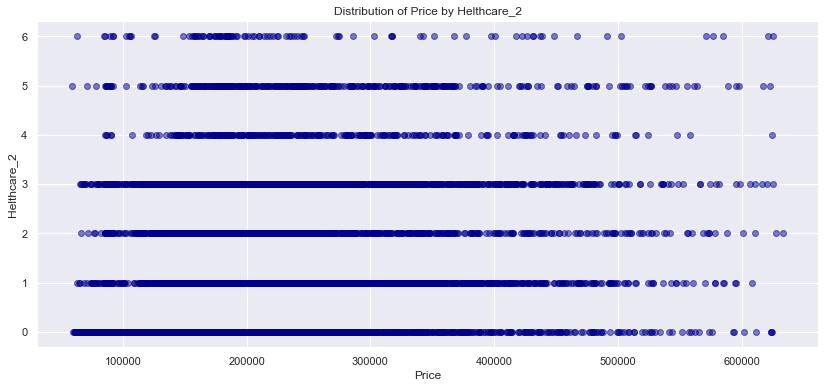

In [323]:
plt.figure(figsize=(14, 6))

plt.scatter(raw_data['Price'], raw_data['Helthcare_2'], alpha=0.5, color='darkblue')

plt.xlabel('Price')
plt.ylabel('Helthcare_2')
plt.title('Distribution of Price by Helthcare_2');

In [324]:
# поэтому переведем его в бинарные факторы
Helth2 = pd.get_dummies(raw_data['Helthcare_2'])
raw_data[Helth2.columns] = Helth2
raw_data = raw_data.rename(columns={1:'Health_care_1', 2:'Health_care_2',3:'Health_care_3',4:'Health_care_4',5:'Health_care_5',6:'Health_care_6'})
raw_data.sample(10)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare                Floor           HouseFloor            HouseYear            Ecology_1             Social_1             Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square  0  Health_care_1  Health_care_2  Health_care_3  Health_care_4  Health_care_5  Health_care_6
631     4857           6             2.000000            63.047343            41.079923            10.000000             6.000000            25.000000         2,016.000000             0.243205             5.000000             0.000000            0        0       171,909.534948  learn        0        1        0        1          0          1             65.000000  1              0              0              0              0              0              0
8085    6088          27             2.000000            67.978744            66.978744             1.000000            12.000000            19.000000         1,977.000000             0.211401             9.000000             1.000000            0        1       133,593.922898  learn        0        1        0        1          0          1                   nan  1              0              0              0              0              0              0
2661    7589          88             2.000000            55.508088            35.728644             9.000000            13.000000            17.000000         1,975.000000             0.127376            43.000000             3.000000            3        9       262,742.511519  learn        0        1        0        1          0          1             64.000000  0              0              0              1              0              0              0
7378    8557          25             2.000000            43.033149            31.502118             5.000000             4.000000             5.000000         1,960.000000             0.069753            53.000000             4.000000            1       11       249,958.536568  learn        0        1        0        1          0          1             73.000000  0              1              0              0              0              0              0
8319    9244           6             3.000000            79.967167             2.299716             1.000000             8.000000            17.000000         1,977.000000             0.243205             5.000000             0.000000            0        0       203,302.643146  learn        0        1        0        1          0          1              3.000000  1              0              0              0              0              0              0
2630    9964           9             3.000000            78.124991            43.950101             9.000000            10.000000            11.000000         2,015.000000             0.161532            25.000000             1.000000            2        4       220,558.547094  learn        0        1        0        1          0          1             56.000000  0              0              1              0              0              0              0
6696   13652           6             2.000000            66.563693            35.360740            13.000000            11.000000            25.000000         2,016.000000             0.243205             5.000000             0.000000            0        0       187,397.035756  learn        0        1        0        1          0          1             53.000000  1              0              0              0              0              0              0
6673    3072         129             1.000000            25.543282            12.875995             6.000000             5.000000             5.000000         1,961.000000             0.051942            17.000000             7.000000            2        0       115,342.222937  learn        0        1        0        1          0          1    

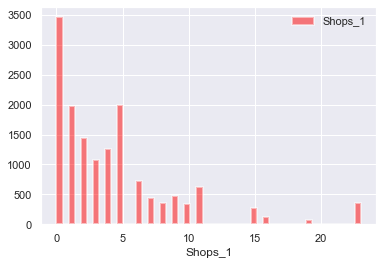

In [325]:
plt.hist(raw_data['Shops_1'], bins=50, label="Shops_1", alpha=0.5, linewidth=2, color='red')
# plt.xlim(0, 0.55)
plt.legend()
plt.xlabel('Shops_1')
plt.show()
# видим, что признак похож на категорию

In [326]:
raw_data['Shops_1'].value_counts() # везде заполнен и похож на катиегориальную фичу, потому что уникаьных значений мало. Скорее всего это просто количество магазинов вокруг в каком-то радиусе, поэтому 

0     3461
5     1993
1     1974
2     1448
4     1253
3     1077
6      729
11     625
9      476
7      441
23     363
8      358
10     332
15     265
16     122
19      68
Name: Shops_1, dtype: int64

In [327]:
# # переведем его в бинарные факторы
# Shops = pd.get_dummies(raw_data['Shops_1'])
# raw_data[Shops.columns] = Shops
# raw_data = raw_data.rename(columns={0:'Shops_count_0', 
#                                     1:'Shops_count_1', 
#                                     2:'Shops_count_2',
#                                     3:'Shops_count_3',
#                                     4:'Shops_count_4',
#                                     5:'Shops_count_5',
#                                     6:'Shops_count_6',
#                                     7:'Shops_count_7',
#                                     8:'Shops_count_8',
#                                     9:'Shops_count_9',
#                                     10:'Shops_count_10',
#                                     11:'Shops_count_11',                                    
#                                     15:'Shops_count_15',
#                                     16:'Shops_count_16',
#                                     19:'Shops_count_19',
#                                     23:'Shops_count_23'
#                                    })
# raw_data.sample(10)

In [328]:
len(raw_data.columns)-1 # суммарное количество факторов

29

In [329]:
raw_data.to_pickle('raw_data_10.pkl')

# Здесь обработаем районы

In [330]:
raw_data = pd.read_pickle('raw_data_10.pkl')
raw_data.sample(10)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare                Floor           HouseFloor            HouseYear            Ecology_1             Social_1             Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square  0  Health_care_1  Health_care_2  Health_care_3  Health_care_4  Health_care_5  Health_care_6
739    13435          94             2.000000            41.628584            24.353380             6.000000            12.000000            12.000000         1,970.000000             0.282798            33.000000             2.000000            0        6       200,863.467925  learn        0        1        0        1          0          1             59.000000  1              0              0              0              0              0              0
12338   8658          62             2.000000            44.460953            30.554274             5.000000             4.000000             5.000000         1,974.000000             0.072158             2.000000             1.000000            0        0                  nan   test        0        1        0        1          1          0             69.000000  1              0              0              0              0              0              0
7351    8084           6             2.000000            67.336830            66.336830             1.000000             3.000000            17.000000         1,977.000000             0.243205             5.000000             0.000000            0        0       190,349.794222  learn        0        1        0        1          0          1                   nan  1              0              0              0              0              0              0
13917  10985         121             4.000000            80.439346            55.440318             8.000000             4.000000            12.000000         1,985.000000             0.212515            19.000000            16.000000            3        7                  nan   test        0        1        0        1          0          1             69.000000  0              0              0              1              0              0              0
1679    2345          58             2.000000            45.268221            30.711901             6.000000             1.000000            12.000000         1,973.000000             0.310199            11.000000             1.000000            0        0        88,295.677360  learn        0        1        0        1          0          1             68.000000  1              0              0              0              0              0              0
12271  11491          54             1.000000            78.181873            75.203901             1.000000             1.000000            15.000000         2,017.000000             0.006076            30.000000             0.000000            6        6                  nan   test        0        1        0        1          0          1             96.000000  0              0              0              0              0              0              1
12153  13713         146             1.000000            41.248933            20.844323             8.000000             5.000000            17.000000         1,988.000000             0.236108            16.000000            27.000000            3       10                  nan   test        0        1        0        1          0          1             51.000000  0              0              0              1              0              0              0
271     7674          30             2.000000            51.283020            51.575295             1.000000             5.000000            17.000000         1,977.000000             0.000078            22.000000           141.000000            3       23       174,735.177184  learn        0        1        0        1          0          1    

In [331]:
districts = raw_data['DistrictId'].value_counts()

In [332]:
raw_data['DistrictId_counts'] = raw_data['DistrictId'].map(dict(districts))
raw_data.sample(2)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare                Floor           HouseFloor            HouseYear            Ecology_1             Social_1             Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square  0  Health_care_1  Health_care_2  Health_care_3  Health_care_4  Health_care_5  Health_care_6  DistrictId_counts
8488    7275          95             4.000000            99.039161            71.575839            11.000000             2.000000             3.000000         1,942.000000             0.000699            14.000000            24.000000            0        3       624,156.003381  learn        0        1        0        1          0          1             72.000000  1              0              0              0              0              0              0                 25
11854  11128          21             2.000000            42.206217            26.426549             5.000000             5.000000             5.000000         1,963.000000             0.034331            25.000000             3.000000            0        4                  nan   test        0        1        0        1          0          1             63.000000  1              0              0              0              0              0              0                235

In [333]:
df = raw_data[['DistrictId_counts','Price']]
corr = df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

# Погенерируем новые фичи

In [334]:
feature_num_names = ['Rooms','Square','LifeSquare','KitchenSquare','HouseFloor','Ecology_1','Social_1','Social_3','Shops_1','LifeSquare_on_Square','DistrictId_counts']

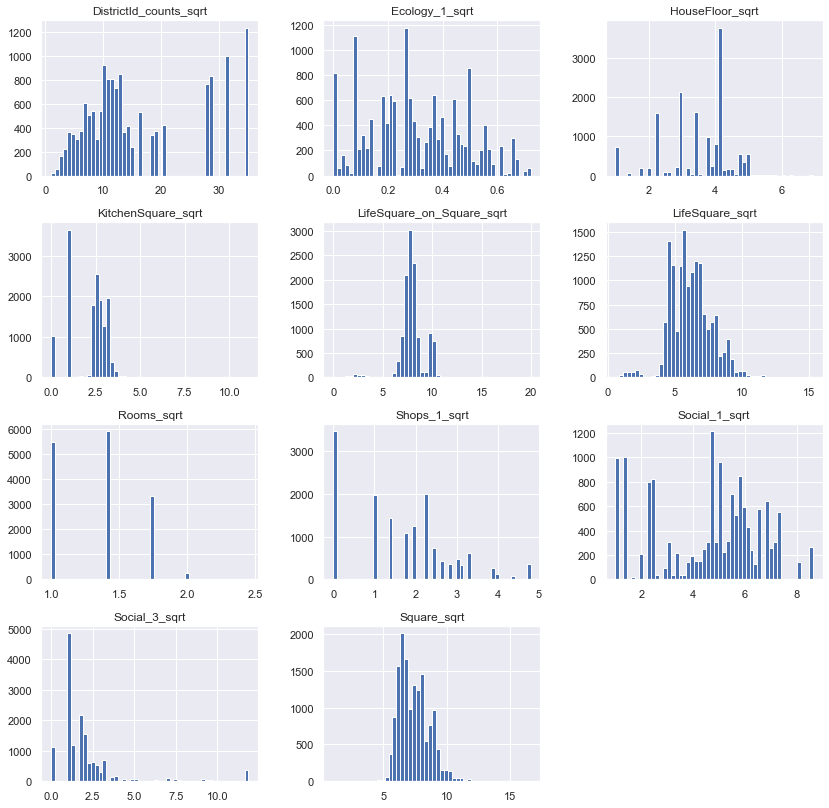

In [335]:
feature_sqrt_names = []
for f in feature_num_names:
    raw_data[f + '_sqrt'] = np.sqrt(raw_data[f])
    feature_sqrt_names.append(f + '_sqrt')
raw_data[feature_sqrt_names].hist(figsize=(14,14), bins=50, grid=True);

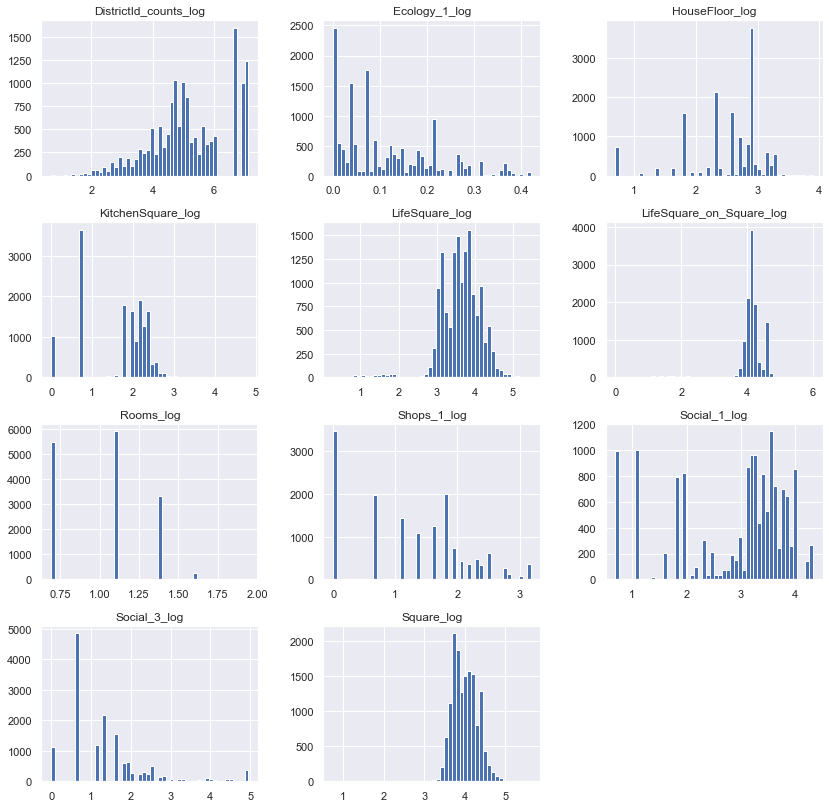

In [336]:
feature_log_names = []
for f in feature_num_names:
    raw_data[f + '_log'] = np.log(raw_data[f]+1)
    feature_log_names.append(f + '_log')
    
raw_data[feature_log_names].hist(figsize=(14,14), bins=50, grid=True);

In [337]:
raw_data['Social_3_test'] = raw_data['Social_3']/raw_data['Social_3'].mean()
raw_data['Social_1_test'] = raw_data['Social_1']/raw_data['Social_1'].mean()
raw_data['St3'] = raw_data['Social_1_test'] + raw_data['Social_3_test']

In [338]:
raw_data['fiz'] = raw_data.apply(lambda x: calc_(x['Square'],x['Rooms'],x['Social_1_log'],x['Floor'],x['HouseYear']), axis=1)

In [339]:
rooms = raw_data['Rooms'].value_counts()
rooms

2.000000    5909
1.000000    5470
3.000000    3340
4.000000     241
5.000000      23
6.000000       2
Name: Rooms, dtype: int64

In [340]:
Rooms = raw_data['Rooms'].value_counts()
raw_data['Rooms_counts'] = raw_data['Rooms'].map(dict(Rooms))

In [341]:
HouseFloor = raw_data['HouseFloor'].value_counts()
raw_data['HouseFloor_counts'] = raw_data['HouseFloor'].map(dict(HouseFloor))

In [342]:
HouseYear = raw_data['HouseYear'].value_counts()
raw_data['HouseYear_counts'] = raw_data['HouseYear'].map(dict(HouseYear))

In [343]:
raw_data.sample(10)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare                Floor           HouseFloor            HouseYear            Ecology_1             Social_1             Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square  0  Health_care_1  Health_care_2  Health_care_3  Health_care_4  Health_care_5  Health_care_6  DistrictId_counts           Rooms_sqrt          Square_sqrt      LifeSquare_sqrt   KitchenSquare_sqrt      HouseFloor_sqrt       Ecology_1_sqrt        Social_1_sqrt        Social_3_sqrt         Shops_1_sqrt  LifeSquare_on_Square_sqrt  DistrictId_counts_sqrt            Rooms_log           Square_log       LifeSquare_log    KitchenSquare_log       HouseFloor_log        Ecology_1_log         Social_1_log         Social_3_log          Shops_1_log  LifeSquare_on_Square_log  DistrictId_counts_log        Social_3_test        Social_1_test  \
13069   6828          27             1.000000            56.589759            56.589759             0.000000             7.000000            17.000000         1,977.000000             0.075424            11.000000             1.000000            0        0                  nan   test        0        1        0        1          0          1                   nan  1              0              0              0              0              0              0               1237             1.000000             7.522617             7.522617             0.000000             4.123106             0.274634             3.316625             1.000000             0.000000                        nan               35.171011             0.693147             4.053345             4.053345             0.000000             2.890372             0.072715             2.484907             0.693147             0.000000                       nan               7.121252             0.115738             0.440978   
5195     847          74             2.000000            73.314975            74.131261             1.000000             6.000000             6.000000         1,977.000000             0.075779             6.000000             3.000000            0        2       254,005.381863  learn        0        1        0        1          0          1            101.000000  1              0              0              0              0              0              0                175             1.414214             8.562416             8.609951             1.000000             2.449490             0.275279             2.449490             1.732051             1.414214                  10.049876               13.228757             1.098612             4.308312             4.319237             0.693147             1.945910             0.073045             1.945910             1.386294             1.098612                  4.624973               5.170484             0.347215             0.240534   
13285   3282          93             1.000000            39.734068            21.235416             8.000000             5.000000            14.000000         1,986.000000             0.521867            25.000000             1.000000            0        0                  nan   test        0        1        0        1          0          1             53.000000  1              0              0              0              0              0              0                113             1.000000             6.303497             4.608190             2.828427             3.741657             0.722404             5.000000             1.000000             0.000000                   7.280110               10.630146             0.693147             3.707065             3.101686             2.197225             2.708050             0.419938             3.258097             0.693147             0.000000                  3.988984               4.736198             0.115738             1.002223   
1271    58

In [344]:
corr = raw_data.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# Посмотрим общую корееляцию

In [346]:
# Какие-то влияния появились, но много коррелирующих друг с другом факторов. Иху нужно убрать, чтобы не путать модель

In [347]:
raw_data.to_pickle('raw_data_11.pkl')

In [398]:
raw_data = pd.read_pickle('raw_data_11.pkl')
raw_data.sample(10)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare                Floor           HouseFloor            HouseYear            Ecology_1             Social_1             Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square  0  Health_care_1  Health_care_2  Health_care_3  Health_care_4  Health_care_5  Health_care_6  DistrictId_counts           Rooms_sqrt          Square_sqrt      LifeSquare_sqrt   KitchenSquare_sqrt      HouseFloor_sqrt       Ecology_1_sqrt        Social_1_sqrt        Social_3_sqrt         Shops_1_sqrt  LifeSquare_on_Square_sqrt  DistrictId_counts_sqrt            Rooms_log           Square_log       LifeSquare_log    KitchenSquare_log       HouseFloor_log        Ecology_1_log         Social_1_log         Social_3_log          Shops_1_log  LifeSquare_on_Square_log  DistrictId_counts_log        Social_3_test        Social_1_test  \
6806    5990          62             1.000000            45.581739            45.169427            10.000000             8.000000            17.000000         2,019.000000             0.072158             2.000000             1.000000            0        0       132,203.174887  learn        0        1        0        1          1          0             99.000000  1              0              0              0              0              0              0                369             1.000000             6.751425             6.720820             3.162278             4.123106             0.268622             1.414214             1.000000             0.000000                   9.949874               19.209373             0.693147             3.841209             3.832318             2.397895             2.890372             0.069673             1.098612             0.693147             0.000000                  4.605170               5.913503             0.115738             0.080178   
5977   10058           1             1.000000            39.540085            38.540085             1.000000            14.000000            17.000000         1,977.000000             0.007122             1.000000             1.000000            0        1       142,273.898845  learn        0        1        0        1          0          1                   nan  1              0              0              0              0              0              0                996             1.000000             6.288091             6.208066             1.000000             4.123106             0.084394             1.000000             1.000000             1.000000                        nan               31.559468             0.693147             3.702291             3.677315             0.693147             2.890372             0.007097             0.693147             0.693147             0.693147                       nan               6.904751             0.115738             0.040089   
7053   15010          34             3.000000            87.097921            80.375732            10.000000            10.000000            25.000000         2,017.000000             0.069753            53.000000             4.000000            1       11       332,858.081130  learn        0        1        0        1          0          1             92.000000  0              1              0              0              0              0              0                172             1.732051             9.332627             8.965251             3.162278             5.000000             0.264109             7.280110             2.000000             3.316625                   9.591663               13.114877             1.386294             4.478449             4.399077             2.397895             3.258097             0.067428             3.988984             1.609438             2.484907                  4.532599               5.153292             0.462954             2.124713   
8330   122

In [399]:
raw_data['RoomSquare'] = raw_data['Square'] / raw_data['Rooms']

In [400]:
raw_data['PriceOneRoom'] = raw_data['Price'] / raw_data['Rooms']
raw_data['PriceOneRoom'].describe()

count           9,985.000000
mean          124,116.674451
std            50,057.985039
min            20,585.693968
25%            89,449.749822
50%           114,974.432440
75%           152,995.355076
max           491,816.404219
Name: PriceOneRoom, dtype: float64

In [401]:
price_by_district = raw_data.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'mean'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

price_by_district['PriceOneRoomByDistrict'] = price_by_district['PriceOneRoomByDistrict'].fillna(np.mean(price_by_district['PriceOneRoomByDistrict']))

In [402]:
raw_data = raw_data.merge(price_by_district, on=['DistrictId'], how='left').set_index(raw_data.index)

In [403]:
raw_data.sample(10)

Id  DistrictId                Rooms               Square           LifeSquare        KitchenSquare                Floor           HouseFloor            HouseYear            Ecology_1             Social_1             Social_3  Helthcare_2  Shops_1                Price   type  A_eco_2  B_eco_2  A_eco_3  B_eco_3  A_shops_2  B_shops_2  LifeSquare_on_Square  0  Health_care_1  Health_care_2  Health_care_3  Health_care_4  Health_care_5  Health_care_6  DistrictId_counts           Rooms_sqrt          Square_sqrt      LifeSquare_sqrt   KitchenSquare_sqrt      HouseFloor_sqrt       Ecology_1_sqrt        Social_1_sqrt        Social_3_sqrt         Shops_1_sqrt  LifeSquare_on_Square_sqrt  DistrictId_counts_sqrt            Rooms_log           Square_log       LifeSquare_log    KitchenSquare_log       HouseFloor_log        Ecology_1_log         Social_1_log         Social_3_log          Shops_1_log  LifeSquare_on_Square_log  DistrictId_counts_log        Social_3_test        Social_1_test  \
9179   13481          94             1.000000            34.860478            19.529107             6.000000             3.000000             9.000000         1,972.000000             0.282798            33.000000             2.000000            0        6       173,965.729530  learn        0        1        0        1          0          1             56.000000  1              0              0              0              0              0              0                132             1.000000             5.904276             4.419175             2.449490             3.000000             0.531787             5.744563             1.414214             2.449490                   7.483315               11.489125             0.693147             3.579636             3.021844             1.945910             2.302585             0.249043             3.526361             1.098612             1.945910                  4.043051               4.890349             0.231477             1.322935   
14412   3644           6             3.000000            82.504103            81.504103             1.000000            17.000000            17.000000         1,977.000000             0.243205             5.000000             0.000000            0        0                  nan   test        0        1        0        1          0          1                   nan  1              0              0              0              0              0              0                767             1.732051             9.083177             9.027962             1.000000             4.123106             0.493158             2.236068             0.000000             0.000000                        nan               27.694765             1.386294             4.424896             4.412848             0.693147             2.890372             0.217692             1.791759             0.000000             0.000000                       nan               6.643790             0.000000             0.200445   
2788   15916         108             2.000000            56.006782            32.492074             9.000000            10.000000            17.000000         2,006.000000             0.019509            25.000000             4.000000            1        1       384,475.370661  learn        0        1        0        1          0          1             58.000000  0              1              0              0              0              0              0                 37             1.414214             7.483768             5.700182             3.000000             4.123106             0.139674             5.000000             2.000000             1.000000                   7.615773                6.082763             1.098612             4.043170             3.511309             2.302585             2.890372             0.019321             3.258097             1.609438             0.693147                  4.077537               3.637586             0.462954             1.002223   
4328    12

In [404]:
raw_data.type.value_counts()

learn    9985
test     5000
Name: type, dtype: int64

In [405]:
raw_data.corr(method='pearson').reset_index()[['index','Price']].sort_values('Price', ascending=False)

index                Price
14                      Price             1.000000
55                        fiz             0.701557
31                Square_sqrt             0.582343
3                      Square             0.579563
2                       Rooms             0.576056
30                 Rooms_sqrt             0.567154
42                 Square_log             0.566184
41                  Rooms_log             0.563361
61     PriceOneRoomByDistrict             0.516018
60               PriceOneRoom             0.341448
4                  LifeSquare             0.303098
32            LifeSquare_sqrt             0.300898
47               Social_1_log             0.296148
36              Social_1_sqrt             0.287974
33         KitchenSquare_sqrt             0.277754
49                Shops_1_log             0.275149
43             LifeSquare_log             0.274430
44          KitchenSquare_log             0.273667
1                  DistrictId             0.265725
38               Shops_1_sqrt             0.260399
53              Social_1_test             0.258023
10                   Social_1             0.258023
12                Helthcare_2             0.253786
5               KitchenSquare             0.249774
48               Social_3_log             0.241360
13                    Shops_1             0.180399
37              Social_3_sqrt             0.165271
23              Health_care_1             0.134760
54                        St3             0.130790
27              Health_care_5             0.119702
6                       Floor             0.114772
26              Health_care_4             0.089794
7                  HouseFloor             0.086751
25              Health_care_3             0.085195
34            HouseFloor_sqrt             0.079306
45             HouseFloor_log             0.072093
20                  B_shops_2             0.070303
11                   Social_3             0.069813
52              Social_3_test             0.069813
17                    A_eco_3             0.052895
24              Health_care_2             0.045568
28              Health_care_6             0.038987
8                   HouseYear             0.035888
16                    B_eco_2             0.022347
50   LifeSquare_on_Square_log             0.019347
0                          Id             0.008779
39  LifeSquare_on_Square_sqrt             0.000784
21       LifeSquare_on_Square            -0.021002
15                    A_eco_2            -0.022347
35             Ecology_1_sqrt            -0.027254
46              Ecology_1_log            -0.038883
9                   Ecology_1            -0.042721
18                    B_eco_3            -0.052895
19                  A_shops_2            -0.070303
57          HouseFloor_counts            -0.134164
59                 RoomSquare            -0.214228
58           HouseYear_counts            -0.232924
22                          0            -0.291751
29          DistrictId_counts            -0.378406
40     DistrictId_counts_sqrt            -0.411313
51      DistrictId_counts_log            -0.425957
56               Rooms_counts            -0.465806

In [406]:
# оставляем значащие фичи:
deleted_features = ['LifeSquare_on_Square','LifeSquare_on_Square_log','LifeSquare_on_Square_sqrt','LifeSquare_log','Rooms_sqrt','Rooms_log','Square','Square_log',
                         'KitchenSquare','KitchenSquare_log','Shops_1_log','Shops_1_sqrt','Social_1_sqrt','Social_1_test','Social_3_test','Social_3_log','Social_3_sqrt',
                         'Health_care_3','Floor','DistrictId_counts_sqrt','Health_care_4', 'LifeSquare_sqrt','St3', 'Ecology_1_log',
'DistrictId_counts','A_eco_3','Social_1', 'HouseFloor_log','HouseFloor_sqrt','B_eco_2','Ecology_1_sqrt','A_eco_2','PriceOneRoom',0]

In [407]:
raw_data = raw_data.drop(list(set(deleted_features)), axis=1)

In [408]:
corr = raw_data.corr(method='pearson').reset_index()[['index','Price']].sort_values('Price', ascending=False)
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [409]:
corr = raw_data.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [411]:
raw_data.to_pickle('raw_data_12.pkl')

# ПРОГНОЗИРУЕМ

In [413]:
raw_data = pd.read_pickle('raw_data_12.pkl')
raw_data.sample(10)

Id  DistrictId                Rooms           LifeSquare           HouseFloor            HouseYear            Ecology_1             Social_3  Helthcare_2  Shops_1                Price   type  B_eco_3  A_shops_2  B_shops_2  Health_care_1  Health_care_2  Health_care_5  Health_care_6          Square_sqrt   KitchenSquare_sqrt         Social_1_log  DistrictId_counts_log                  fiz  Rooms_counts  HouseFloor_counts  HouseYear_counts           RoomSquare  PriceOneRoomByDistrict
7068    8923          27             1.000000            20.204495            17.000000         1,977.000000             0.017647             1.000000            0        0       125,555.548716  learn        1          0          1              0              0              0              0             6.649676             2.645751             1.098612               7.121252         5,849.375893          5470               3759              3942            44.218190           98,877.092453
11644   6394          48             2.000000            32.729633            16.000000         1,984.000000             0.041125             5.000000            1       10                  nan   test        1          0          1              1              0              0              0             7.662095             3.000000             3.850148               4.955827        44,392.213852          5909                814               122            29.353848          170,306.775726
5133    7826          41             3.000000            48.133292            12.000000         1,972.000000             0.175055             3.000000            1        0       325,730.730440  learn        1          0          1              1              0              0              0             8.114389             3.000000             3.610918               4.882802        63,927.600931          3340               1611               271            21.947768          126,310.640349
1642   12436           9             4.000000            59.248532            14.000000         1,994.000000             0.161532             1.000000            2        4       277,786.015610  learn        1          0          1              0              1              0              0             9.624059             2.828427             3.258097               6.054439       140,074.261752           241                970                84            23.155629          105,191.274746
4272   12072         138             1.000000            19.423808            24.000000         2,004.000000             0.195781             2.000000            0        2       209,421.875406  learn        1          0          1              0              0              0              0             6.419146             3.162278             3.610918               3.871201        15,578.879628          5470                276               145            41.205430          135,463.438188
3821   13588           5             1.000000            17.514986            17.000000         1,979.000000             0.150818             4.000000            4        5       186,291.350909  learn        1          0          1              0              0              0              0             6.451366             3.162278             2.833213               3.988984        13,469.729726          5470               3759               161            41.620121          157,667.182233
9888    4153          23             1.000000            30.397748             9.000000         2,015.000000             0.034656             3.000000            0        0        70,098.380568  learn        1          0          1              0              0              0              0             5.734067             1.000000             1.945910               6.721426         5,081.129970          5470               2116               457            32.879523           80,902.751954
8938    4495          90             1.000000     

In [414]:
X = raw_data[raw_data['type']=='learn'].drop(['Price','type','Id'], axis=1)
y = raw_data[raw_data['type']=='learn']['Price']

In [415]:
print(X.shape)
print(y.shape)

(9985, 26)
(9985,)


In [417]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=777)

In [418]:
X_train.shape, y_train.shape

((6989, 26), (6989,))

In [421]:
"""
Было в начале
R2 на обучающей выборке: 0.739 +- 0.035
R2 на валидационной выборке: 0.741 +- 0.053
"""

'\nБыло в начале\nR2 на обучающей выборке: 0.739 +- 0.035\nR2 на валидационной выборке: 0.741 +- 0.053\n'

In [420]:
cv_score_train = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=42))
mean_train = cv_score_train.mean()
std_train = cv_score_train.std()

cv_score_holdout = cross_val_score(model, X_holdout, y_holdout, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=42))
mean_holdout = cv_score_holdout.mean()
std_holdout = cv_score_holdout.std()

print('R2 на обучающей выборке: {:.3f} +- {:.3f}'.format(mean_train, std_train))
print('R2 на валидационной выборке: {:.3f} +- {:.3f}'.format(mean_holdout, std_holdout))

R2 на обучающей выборке: 0.751 +- 0.045
R2 на валидационной выборке: 0.740 +- 0.037


In [422]:
X_test = raw_data[raw_data['type']=='test'].drop(['Price','type'], axis=1)
X_test.sample(2)

Id  DistrictId                Rooms           LifeSquare           HouseFloor            HouseYear            Ecology_1             Social_3  Helthcare_2  Shops_1  B_eco_3  A_shops_2  B_shops_2  Health_care_1  Health_care_2  Health_care_5  Health_care_6          Square_sqrt   KitchenSquare_sqrt         Social_1_log  DistrictId_counts_log                  fiz  Rooms_counts  HouseFloor_counts  HouseYear_counts           RoomSquare  PriceOneRoomByDistrict
13005  16390           3             2.000000            31.064621            17.000000         1,984.000000             0.050900             1.000000            2        3        1          0          1              0              1              0              0             7.352054             3.000000             3.784190               4.934474        40,872.310831          5909               3759               122            27.026352          115,759.430043
12292  14622           1             2.000000            56.316674            17.000000         1,977.000000             0.007122             1.000000            0        1        1          0          1              0              0              0              0             7.479731             1.000000             0.693147               6.904751        14,801.663578          5909               3759              3942            27.973189          114,799.917224

In [424]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_test['Id'].copy()
X_test.set_index('Id', inplace=True)
X_test.sample(2)

DistrictId                Rooms           LifeSquare           HouseFloor            HouseYear            Ecology_1             Social_3  Helthcare_2  Shops_1  B_eco_3  A_shops_2  B_shops_2  Health_care_1  Health_care_2  Health_care_5  Health_care_6          Square_sqrt   KitchenSquare_sqrt         Social_1_log  DistrictId_counts_log                  fiz  Rooms_counts  HouseFloor_counts  HouseYear_counts           RoomSquare  PriceOneRoomByDistrict
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
11027          30             1.000000            40.692862             1.000000         1,977.000000             0.000078           141.000000            3       23        1          0          1              0              0              0              0             6.457001             1.000000             3.135494               5.834811        10,603.037106          5470                725              3942            41.692862          102,526.701177
5418           62             2.000000            73.473629            17.000000         1,977.000000             0.072158             1.000000            0        0        1          1          0              0              0              0              0             8.629810             1.000000             1.098612               5.913503        19,703.395564          5909               3759              3942            37.236814          106,918.454262

In [425]:
print('В трейне:' ,  X_train.shape)
print('В тесте', X_test.shape)

В трейне: (6989, 26)
В тесте (5000, 26)


In [426]:
X_total = raw_data[raw_data['type'].isin(['learn','holdout'])].drop(['Price','type','Id'], axis=1)
y_total = raw_data[raw_data['type'].isin(['learn','holdout'])]['Price']

In [427]:
X_total.shape

(9985, 26)

In [429]:
model.fit(X_total, y_total)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.04, max_delta_step=0,
             max_depth=4, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             random_state=777, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [430]:
y_test_preds = model.predict(X_test)

In [431]:
preds_final['Price'] = y_test_preds
preds_final.head()

Id                Price
13283  4834       191,220.328125
12816  6607       141,121.453125
12826  7319       135,921.140625
10022  4176       176,131.406250
11000  6663       178,988.031250

In [432]:
preds_final.to_csv('predictions.csv', index=False)

Среднее значение: 215258.0
Медиана: 194896.0
Мода: 203806.0


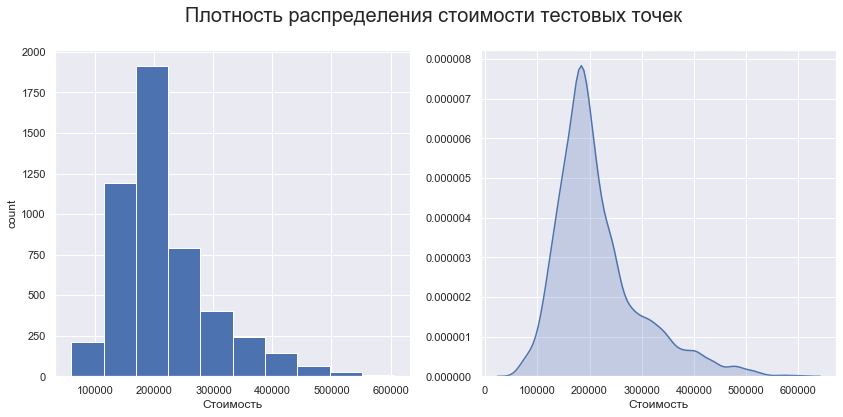

In [433]:
#Видим, что цена на тестовых точек по прогнозу похоже имеет тоже логнормальное распределение

plt.figure(figsize = (14, 6))

plt.subplot(121)
preds_final['Price'].hist(edgecolor='white')
plt.ylabel('count')
plt.xlabel('Стоимость')

plt.subplot(122)
sns.kdeplot(preds_final['Price'], shade=True, legend=False)
plt.xlabel('Стоимость')

plt.suptitle('Плотность распределения стоимости тестовых точек', size=20)

target_mean = round(preds_final['Price'].mean(), 2)
target_median = preds_final['Price'].median()
target_mode = preds_final['Price'].mode()[0]

print(f"Среднее значение: {np.round(target_mean,0)}\nМедиана: {np.round(target_median,0)}\nМода: {np.round(target_mode,0)}")